# Дипломная работа:
## Построение скоринг модели для клиентов банка, которая предсказывает вероятность дефолта клиента исходя из анкетных данных, портфельных данных банка, кредитной истории клиента в кредитном бюро и соц.отчислениях из центра выплаты пенсий

### Импортируем библиотеки

In [1]:
from pandas import Series
import pandas as pd
import numpy as np
from datetime import date
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import os
from tqdm import tqdm
import sys
import random
import pandas_profiling

from bs4 import BeautifulSoup
import requests 
import csv

from threading import Thread
import queue
import time
import scikit_posthocs as sp

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif, mutual_info_classif
from catboost import CatBoostRegressor, CatBoostClassifier, Pool, cv
import sklearn.metrics
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingRegressor, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import optuna
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import plot_confusion_matrix
import scikitplot as skplt

# plotly standard imports
import plotly.graph_objs as go

# Cufflinks wrapper on plotly
import cufflinks


# Options for pandas
pd.options.display.max_columns = 30

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from plotly.offline import iplot
cufflinks.go_offline()

import h2o
from h2o.automl import H2OAutoML

### Используемые функции для обработки и визуализации

In [2]:
def VizCounterBar(df, column, title, max_values=0):
    """
    Визуализация количества значений в dataframe
    df - датафрейм, column - столбец, title - подпись
    max_values - максимальное количество значений для отображения/ 0 - все
    """
    
    if max_values >0:
        col_values = df[column].value_counts().nlargest(max_values).sort_values(ascending=True)
    else:
        col_values = df[column].value_counts(ascending=True)
    
    fig, ax = plt.subplots()
    plt.rcParams['figure.figsize'] = (12,12)
    plt.figure 
       
    ax = col_values.plot(kind='barh', title = title)
    ax.set_facecolor('lightgrey')
    ax.set_xlim(0, col_values.max()*1.15)
    
    for i, v in enumerate(col_values):
        plt.text(v, i, " "+str(v), va='center')
    
    plt.show()
    
def ShowPlotsLog(column):
    """
    Визуализация распределения значений столбца в dataframe после логарифмирования
    column - столбец в dataframe
    """
        
    df[column]=np.log(df[column]+1)
    df[column].hist(figsize=(10,5))

def Log(column):
    """
     логарифмированиt данных
    column - столбец в dataframe
    """
        
    df[column]=np.log(df[column]+1)   
    
    
def ShowBoxPlots(column):
    """
    Boxplot относительно целевой переменной в dataframe
    column - столбец в dataframe
    x - целевая переменная 
    """
    fig,ax=plt.subplots(figsize=(10,4))
    sns.boxplot(y=column,x='Default', data=df)
    plt.title(column)
    plt.show()
    
def Outliers(column):
    """
    Определение квартилей и границ выбросов для признаков в dataframe
    column - столбец в dataframe
    """
    
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    print (column)
    k = 0
    for i in df[column]:
        if i <= low or i >= up:
            k+= 1
    if k > 0:
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
              , "IQR: {}, ".format(IQR),"Границы выбросов: [{}, {}],".format(low,up), 'Количество выбросов - ', k)
    else:
        print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
              , "IQR: {}, ".format(IQR), "Границы выбросов: [{}, {}],".format(low,up), 'Выбросов нет') 

def OutliersUniform(column):
    """
    Определяем выбросы и задаем значение внутри границ выбросов в столбце dataframe
    column - столбец в dataframe
    """
  
    x=0
    perc25, perc75 = np.percentile(df[column], [25, 75])
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR
    if type(column[0])==int:
        x=random.randint(low,up)
    else:
        x=random.uniform(low,up)
    for i in range(len(df)):
        if df[column][i] < low or  df[column][i] > up:
            df[column][i] = x      
            
            
def ColInfo(column):
    """
    общая информация по определенному признаку, вроде кол-во пустых значений, мин и макс и тд
    column - столбец в dataframe
    """
    
    print('Количество пропусков: {},'.format(column.isnull().sum()))
    print('{},'.format(column.describe()))
    print('Распределение:\n{},'.format(column.value_counts()))
    column.hist(figsize=(7,5)) 
    
def ShowValuesOnBars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() 
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()/2
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left", va ='center')

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
def CityExtract(column):
    """
    перезаписываем столбец с указанием основных городов, а остальное относим в others
    """
    
    df[column].fillna(0, inplace=True)
    df.loc[:,column] = df.loc[:,column].map(cities_map)
    df[column].fillna(23, inplace=True)
    
def DateOfBirthCorr(row):
    """
    конвертируем дату рождения в формат даты и времени и заполняем пустые значения данными из ИИН
    """
    birthdate = row['dateofbirth']
    if birthdate != 0:
        row['dateofbirth'] = datetime.strptime(str(birthdate), '%Y-%m-%d %H:%M:%S')
    else:
        iin = str(row['iin_x'])
        if iin[6] in ['3', '4']:
            row['dateofbirth'] = datetime.strptime('19'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
        else:
            row['dateofbirth'] = datetime.strptime('20'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
    return row           


### Cловари

In [3]:
## выделяем основные города с 1-22, 0 - нет значений, 23 - прочие села/поселки/мелкие города
cities_map = {0:0,'г.Алматы': 1, 'г.Актау': 2, 'г.Талдыкорган': 3, 'г.Нур-Султан': 4, 'г.Астана': 4, \
          'г.Атырау': 5, 'г.Караганда': 6, 'г.Семей': 7, 'г.Уральск': 8, 'г.Актобе': 9, \
          'г.Усть-Каменогорск': 10, 'г.Костанай': 11, 'г.Павлодар': 12, 'г.Тараз': 13, \
          'г.Кызылорда': 14, 'г.Экибастуз': 15, 'г.Петропавловск': 16, 'г.Кокшетау': 17, \
          'г.Шымкент': 18, 'г.Жезказган': 19, 'г.Темиртау': 20, 'г.Туркестан': 21, 'г.Каскелен': 22}

### Парсим информацию из кредитного бюро и на этом же этапе создаем фичи

In [4]:
def pkb_parse(request):
    """
    парсим все необходимые данные из кредитного бюро
    """
    mysql_statement = f"""select  * from soap_log where requestid like '{request}%' and SERVICE_NAME = 'PKB'"""
    a = pd.read_sql_query(mysql_statement, connection)
    empty_list = [0 for i in range(94)]
    empty_list[0] = request
    try:
        raz = next(iter(a.loc[a.ID == a.ID.max(), 'RESPONSE'])).read()
        dt64 = a.CHANGEDATE.values[0]
        ts = (dt64 - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
       # проверяем на ошибки при выгрузке отчета из кредитного бюро
        time_calc = datetime.utcfromtimestamp(ts)
    except:
        error_text = 'No Soap'
        
        empty_list[-1] = error_text
        return empty_list
    response_pkb1 = ElementTree.fromstring(raz)
    try:
        error_text = response_pkb1.find('.//Errmessage').text
    except:
        error_text = 'OK'
    if response_pkb1.find('.//code').text.split('-')[1] != '0000':
        error_text = response_pkb1.find('.//code', ns).text
        final = error_text
        return final
    elif error_text != 'OK':
        empty_list[-1] = error_text
        return empty_list
    else:
        try:
            pkb_client_dict = pkb_client_data(response_pkb1, time_calc)
        except:
            empty_list[-1] = error_text
            return empty_list
    error_text = ''
    Pkb_contract, Pkb_payment = pkb_contract_payment (response_pkb1, time_calc)
    final_data = pkb_features (Pkb_contract, Pkb_payment, ts, pkb_client_dict)
    final_data = final_data[0] + list(pkb_client_dict.values())
    final_data.append(error_text)

    return final_data
# всего создается 3 таблицы: информация по анкете клиента, информация по всем договорам, 
# вновь созданные признаки основанные на данных из кредитного бюро

def pkb_client_data (response_pkb1, time_calc):
    """
    создаем таблицу с данными по клиенту из кредитного бюро
    """
    pkb_client_dict = {}
    
    # негативный статус клиента
    pkb_client_dict['NegativeStatusOfClient']=response_pkb1.find('.//NegativeStatusOfClient/NegativeStatusOfClient').get('value')
    
    # количество запросов из кредитного бюро за периоды
    pkb_client_dict['Days7'] = len(response_pkb1.findall('.//DetailsQueries7days/query'))
    for i in ['Days30', 'Days90', 'Days120','Days180', 'Days360']:
        pkb_client_dict[i] = int(response_pkb1.find('.//' + i).get('value'))
    
    # поиск негативного статуса в публичных государственных источниках
    for i in ['QamqorList' , 'KgdWanted', 'QamqorAlimony', 'RNUGosZakup', 'FalseBusi',\
              'TerrorList', 'Areears', 'Bankruptcy','L150o10']:
        pkb_client_dict[i] = response_pkb1.find('.//PublicSources/' + i + '/Status').get('id')
        
    # поиск свежего адреса проживания
    for i in (response_pkb1.findall('.//Address')):
        addresstype = i.find('.//AddressType').get('value')
        address_city = []
        if addresstype != "Место рождения":
            address_city.append(i.find('.//City').get('value'))
    pkb_client_dict['Last_city'] = address_city[-1]
        
         
    # анкетные данные
    for i in ['IIN', 'DateOfBirth', 'Gender', 'City', 'Region', 'NumberOfDependents', \
              'Education', 'MatrialStatus', 'EmployeesSalary', 'ZipCode','CellularPhone',\
              'SubjectsEmployment','Citizenship','EconomicActivityGroup','CityOfBirth']:
        pkb_client_dict[i] = response_pkb1.find('.//' + i).get('value').strip()
    pkb_client_dict['DateOfBirth'] = datetime.strptime(pkb_client_dict['DateOfBirth'], '%d.%m.%Y')
    pkb_client_dict['Age'] = relativedelta(time_calc, pkb_client_dict['DateOfBirth']).years
    
    # Создание даты рождения из ИИН-а
    iin = pkb_client_dict['IIN']
    if iin[6] in ['3', '4']:
        birthdate = datetime.strptime('19'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
    else:
        birthdate = datetime.strptime('20'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
    
    # Пол из ИИН и максимальный возраст выхода на пенсию, для мужчин и женщин свой
    if iin[6] in ['3', '6']:
        max_age = 63*12
    else:
        max_age = 60*12
    Age = relativedelta(time_calc, birthdate)
    
    # расчет максимального срока кредита
    pkb_client_dict['max_term'] = max_age - (Age.years * 12 + Age.months + 1)
    return pkb_client_dict


def pkb_contract_payment (response_pkb1, time_calc):
    """
    создаем таблицу с данными по контрактам и платежам по контрактам из кредитного бюро
    """
    columns_value = ["CodeOfContract", "AgreementNumber", "CurrencyCode",  'DateOfApplication',\
               'DateOfCreditStart',  'DateOfCreditEnd', 'DateOfRealRepayment', 'DateAgreementGuarantee',\
               'GuaranteeEvent', 'ClassificationOfContract', 'LastUpdate', 'TotalAmount', 'Amount', 'ResidualAmount', \
                'CreditLimit','NumberOfOutstandingInstalments', 'NumberOfInstalments', 'OutstandingAmount', \
                 'NumberOfOverdueInstalments', 'OverdueAmount', 'MonthlyInstalmentAmount', 'SubjectRole', \
                 'GracePrincipal','GracePay', 'ContractThirdParty', 'ProlongationCount', 'DateOfInserted', \
                 'NumberOfOverdueInstalmentsMax', 'NumberOfOverdueInstalmentsMaxAmount', 'OverdueAmountMax',\
                'SpecialRelationship', 'NominalRate', 'TypeOfGuarantee', 'ValueOfGuarantee', 'TypeOfValueOfGuarantee',\
                'AmountProvisions', 'InterestRate','OverdueAmountMaxDate', 'OverdueAmountMaxCount', 'NumberOfOverdueInstalmentsMaxDate']
    columns_id = ['TypeOfFounding', 'ContractStatus', 'PeriodicityOfPayments', 'MethodOfPayments', \
                  'FinancialInstitution','PurposeOfCredit']

    pkb_contracts = []

    df_cols_payment = ['PAYMENTDATE', 'PAYMENTOVERDUE', 'PAYMENTVALUE', 'PAYMENTFINE', 'PAYMENTPENALTY', 'CHANGEDATE', 'PKB_ID']
    rows_payment= []
    number = 0
    for existence in ['ExistingContracts' , 'TerminatedContracts']:
        for  contract in (response_pkb1.findall('.//' + existence + '/Contract')):
            contract_info = []
            contract_info.append(existence)
            contract_info.append(number)
            for column in columns_value:
                try:
                    contract_info.append(contract.find('.//' + column  ).get('value'))
                except:
                    contract_info.append(np.nan)
            for column in columns_id:
                contract_info.append(contract.find('.//' + column  ).get('id'))
            pkb_contracts.append(contract_info)
            for years in contract.findall('.//Year'):
                year=years.get('title')
                for payments in years.findall('Payment'):
                    PAYMENTDATE=date(int(year), int(payments.get('number')), 1)
                    PAYMENTOVERDUE=payments.get('overdue')
                    PAYMENTVALUE=payments.get('value')
                    PAYMENTFINE=payments.get('fine')
                    PAYMENTPENALTY=payments.get('penalty')
                    CHANGEDATE=datetime.now()

                    if payments.get('title')!="":
                        rows_payment.append([PAYMENTDATE, PAYMENTOVERDUE, PAYMENTVALUE, PAYMENTFINE, PAYMENTPENALTY, CHANGEDATE, number])
            number += 1

    Pkb_contract = pd.DataFrame(pkb_contracts, columns = ['Status', 'PKB_ID'] + columns_value + columns_id) 
    Pkb_payment = pd.DataFrame(rows_payment, columns = df_cols_payment) 
    
    
    # форматирование  Pkb_contract
    
    float_list = ['TotalAmount', 'Amount', 'ResidualAmount', 'CreditLimit', 'NumberOfOutstandingInstalments', \
                'NumberOfInstalments', 'OutstandingAmount','NumberOfOverdueInstalments', 'OverdueAmount', \
                'MonthlyInstalmentAmount', 'NumberOfOverdueInstalmentsMax', \
                'NumberOfOverdueInstalmentsMaxAmount', 'OverdueAmountMax','NominalRate', 'ValueOfGuarantee', \
                'AmountProvisions', 'InterestRate', 'OverdueAmountMaxCount']

    for i in float_list:
        Pkb_contract[i] = pd.to_numeric(Pkb_contract[i].str.replace(r"[a-zA-Z]",'') \
                                      .str.replace(',', '.').str.replace(' ', ''), errors = 'raise').astype(float)
    date_list = ['DateOfApplication', 'DateOfCreditStart', 'DateOfCreditEnd', 'DateOfRealRepayment', \
                 'DateAgreementGuarantee', 'LastUpdate', 'DateOfInserted','OverdueAmountMaxDate',\
                 'NumberOfOverdueInstalmentsMaxDate']
    for i in date_list:
        Pkb_contract[i] = Pkb_contract[i].str.replace('-', '')
        Pkb_contract[i] = pd.to_datetime(Pkb_contract[i], errors='coerce')

    for i in date_list:
        Pkb_contract.loc[Pkb_contract[i].isnull(), i] = time_calc
    
    #  Форматирование Pkb_payment
    for i in ['PAYMENTOVERDUE', 'PAYMENTVALUE', 'PAYMENTFINE', 'PAYMENTPENALTY']:
        Pkb_payment[i] = pd.to_numeric(Pkb_payment[i].str.replace(r"[a-zA-Z]",'').str.replace(',', '.') \
                                       .str.replace(' ', '').str.replace('-', '0'), errors='raise').astype(float)
    try:
        Pkb_payment['PAYMENTDATE'] = pd.to_datetime(Pkb_payment['PAYMENTDATE'])
    except:
        pass
    
    try:
            Pkb_payment['PAYMENTDATE'] = pd.to_datetime(Pkb_payment['PAYMENTDATE'])
    except:
        pass

    return Pkb_contract, Pkb_payment



def pkb_features (Pkb_contract, Pkb_payment, ts, pkb_client_dict):
    """
    создаем таблицу с созданными ранее признаками и генерим новые фичи, все фичи создается на уровне парсинга
    """
    final = []
    time1 = datetime.now()
    time_calc=datetime.utcfromtimestamp(ts)
    

    bvu_list = ['111', '112', '113', '114', '116', '117', '118', '119', '120', '121', '122', '123', '124', \
                '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '136', '137', '138', \
          '139', '140', '141', '142', '143', '144', '151', '152', '153', '154', '155', '156', '157', \
          '158', '159', '160', '161', '162', '163', '164', '165', '167', '168', '169', '170', '171', \
          '172', '173', '174', '175', '176', '177', '178', '179', '180', '181', '182', '183', '184', \
          '185', '186', '187', '188', '189', '190', '191', '192', '193', '194', '195', '196', '197', \
          '198', '199', '200', '201', '202', '203', '204', '205', '207', '208', '209', '210', '211', '213']
    bvu_name='АО КАЗКОММЕРЦБАНК|АКЦИОНЕРНОЕ ОБЩЕСТВО БТА БАНК|АКЦИОНЕРНОЕ ОБЩЕСТВО НАРОДНЫЙ БАНК КАЗАХСТАНА|АО ЦЕСНАБАНК|АО БАНК ЦЕНТР КРЕДИТ|АО БАНКПОЗИТИВ|АО ТЕМІРБАНК|АО СЕНИМ-БАНК|АО АТФБАНК|АО ЖИЛСТРОЙСБЕРБАНК КАЗАХСТАНА|АО КАЗИНВЕСТБАНК|АО СИТИБАНК КАЗАХСТАН|АО БАНК BANK RBK|ДБ АО HSBC БАНК КАЗАХСТАНА|АО KASPI BANK|АО ДБ RBS (KAZAKHSTAN)|АО ДБ ТАИБ КАЗАХСКИЙ БАНК|АО ДБ НАЦ.БАНК ПАКИСТАНА В КАЗАХСТАНЕ|АО ТП БАНК КИТАЯ В Г.АЛМАТЫ|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ АЛМАТЫ ФИНАНС|ТОО ПРОСТОКРЕДИТ|АО ХОУМ КРЕДИТ БАНК|АО ДБ АЛЬФА-БАНК|АО ДБ БАНК КИТАЯ В КАЗАХСТАНЕ|ТОО КТ ЭКСПРЕСС|АО ЭКСИМБАНК КАЗАХСТАН|ТОО РАЙФФАЙЗЕН ЛИЗИНГ КАЗАХСТАН|АО ЕВРАЗИЙСКИЙ БАНК|АО ВАЛЮТ-ТРАНЗИТ БАНК|АО «ДБ «PUNJAB NATIONAL BANK-КАЗАХСТАН».|АО DELTA BANK|АО ДБ КЗИ БАНК|АО НУРБАНК|АСТАНА-ФИНАНС АО|АО ASIACREDIT BANK|119900/ АКЦИОНЕРНОЕ ОБЩЕСТВО КАЗАГРОФИНАНС|ИПОТЕЧНАЯ ОРГАНИЗАЦИЯ БТА ИПОТЕКА АО|ФОНД РАЗВИТИЯ ПРЕДПРИНИМ-ВА ДАМУ|SBERBANK ROSSII ALMATY KAZAKHSTAN|ТОО МКО ТАТ СЕНИМ|АО БРК-ЛИЗИНГ ДОЧЕРНЯЯ ОРГАНИЗАЦИЯ АО БАНК РАЗВИТИЯ КАЗАХСТАНА|АО ИО ЭЛИТСТРОЙ ФИНАНС|ТОО МКО НАРОДНЫЙ КРЕДИТ|АО ФОНД ФИН.ПОДДЕРЖКИ С/Х|АЛЬЯНС БАНК|АО ХОУМ КРЕДИТ КАЗАХСТАН|ТОО МКО KAZBUSINESS ДЕМЕУ|АО ИО БИРЮЗА|МИКРОКРЕДИТНАЯ ОРГАН. АСТАНА-ФИНАНС|АО ИО КАЗИПОТЕКА|HOMEBROKER АО|АО ИО КУРЫЛЫС ИПОТЕКА|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИ|АО ИПОТЕЧНАЯ ОРГАНИЗАЦИЯ АСТАНА-ФИНАНС|АО ЗАМАН-БАНК|АО ЛИЗИНГОВАЯ КОМПАНИЯ АСТАНА-ФИНА..|АО АГРАРНАЯ КРЕДИТНАЯ КОРПОРАЦИЯ|АО КОМПАНИЯ ПО РЕАБИЛИТАЦИИ И УПРАВЛЕНИЮ АКТИВАМИ|АО АЛЬТЕРНАТИВНЫЕ ФИНАНСЫ|АО ИО ДАМУ|АО МЕТРОКОМБАНК|ТОО КТ «МАСТЕР- КРЕДИТ|АО ПРОДОВОЛЬСТВЕННАЯ КОНТРАКТНАЯ КОРПОРАЦИЯ|АО НК КАЗМУНАЙГАЗ|АО ИО ТАТ ИПОТЕКА|ТОО МКО СЕНТРАС КРЕДИТ|АО ФНБ САМРУК-КАЗЫНА|АО БАНК АСТАНА-ФИНАНС|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ KAZMICROFINANCE|АО АЛМАТИНСКАЯ РЕГИОНАЛЬНАЯ ИПОТЕЧНАЯ ОРГАНИЗАЦИЯ|АО ИО КИК|АО ШИНХАН БАНК КАЗАХСТАН|АО ФИНАНСОВАЯ КОМПАНИЯ REAL-INVEST.KZ|ЛИЗИНГ ГРУПП АО|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ АЛТЫН ОРДА|ДО АО БАНК ВТБ (КАЗАХСТАН)|АО «БАНК РАЗВИТИЯ КАЗАХСТАНА»|ТОО МКО ПРОСТО КРЕДИТ|АО БАНК KASSA NOVA|АО ИСЛАМСКИЙ БАНК AL HILAL|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ АЗИАТСКИЙ КРЕДИТНЫЙ ФОНД|ТОО «РЕГИОНАЛЬНЫЙ ИНВЕСТИЦИОННЫЙ ЦЕНТР «МАКСИМУМ»|АО КРЕДИТ АЛТЫН БАНК|ТОО МКО ГАРАНТКАЗФИНАНС|ТОО МКО АКТОБЕ АУЫЛ МИКРОКРЕДИТ|ТОО ТЕХНОЛИЗИНГ|ТОО МКО 1КРЕДИТ|ТОО МКО МИКРОКРЕДИТНЫЙ ДОМ|ТОО МКО АРНУР КРЕДИТ|ТОО МКО  CREDIT SYSTEMS|МКО ЧЕЛСИ ТОО|ТОО МИКРОКРЕДИТНАЯ ОРГАНИЗАЦИЯ SERTA'


    Pkb_contract['term'] = Pkb_contract.apply(lambda x: relativedelta(x['DateOfCreditEnd'], x['DateOfCreditStart'])\
                                              .years * 12 + relativedelta(x['DateOfCreditEnd'], x['DateOfCreditStart'])\
                                              .months, axis = 1).astype(float)
    Pkb_contract.loc[Pkb_contract['term'] < 6, 'term'] = 6
    Pkb_contract['MonthlyInstalmentAmount_alt_kl'] = Pkb_contract['CreditLimit'] / 10
    Pkb_contract['MonthlyInstalmentAmount_alt'] = Pkb_contract['TotalAmount'] / Pkb_contract['term']
    Pkb_contract['MonthlyInstalmentAmount_Max'] = Pkb_contract[["MonthlyInstalmentAmount", "MonthlyInstalmentAmount_alt", \
                                                                "MonthlyInstalmentAmount_alt_kl"]].max(axis = 1)
    

    PAYMENTOVERDUE_table = pd.merge(Pkb_payment, Pkb_contract[['Status', 'PKB_ID', 'TypeOfFounding', \
                                                               'MonthlyInstalmentAmount_Max','NumberOfOverdueInstalmentsMaxDate']], how = 'left', on = ['PKB_ID'])

    # объединение платежей по дате. as_index=False не дает им создать дополнительное поле, с объединенными ячейками
    aggregation_functions = { 'MonthlyInstalmentAmount_Max':'sum'}
    payment_sum=PAYMENTOVERDUE_table[PAYMENTOVERDUE_table['Status'] == 'TerminatedContracts'].groupby(['PAYMENTDATE'], as_index = False)\
    .aggregate(aggregation_functions)    
    payment_sum_all = PAYMENTOVERDUE_table.groupby(['PAYMENTDATE'], as_index = False).aggregate(aggregation_functions)    

    # более 10 000тг, более 10 дней за 3 мес по текущим кредитам
    Prosr_3 = len(PAYMENTOVERDUE_table[(PAYMENTOVERDUE_table['PAYMENTOVERDUE']+PAYMENTOVERDUE_table['PAYMENTPENALTY']  > 10000) & \
                                     (PAYMENTOVERDUE_table['Status'] == 'ExistingContracts') & \
                                     (PAYMENTOVERDUE_table['PAYMENTVALUE'] > 10) & \
                                     (PAYMENTOVERDUE_table['PAYMENTDATE'] > (time_calc - relativedelta(months = +3)))].index)

    # более 10 000тг, более 30 дней за 12 мес по всем кредитам
    Prosr_12 = len(PAYMENTOVERDUE_table[(PAYMENTOVERDUE_table['PAYMENTOVERDUE']+PAYMENTOVERDUE_table['PAYMENTPENALTY'] > 10000)& \
                                        (PAYMENTOVERDUE_table['PAYMENTVALUE'] > 30)& \
                                        (PAYMENTOVERDUE_table['PAYMENTDATE'] > (time_calc - relativedelta(months = +12)))].index)

    # более 10 000тг, более 90 дней за 36 мес по всем кредитам
    Prosr_36 = len(PAYMENTOVERDUE_table[(PAYMENTOVERDUE_table['PAYMENTOVERDUE']+PAYMENTOVERDUE_table['PAYMENTPENALTY'] > 10000)& \
                                      (PAYMENTOVERDUE_table['PAYMENTVALUE'] > 90)& \
                                      (PAYMENTOVERDUE_table['PAYMENTDATE'] > (time_calc - relativedelta(months = +36)))].index)
    Payments_2_years = len(Pkb_payment['PAYMENTDATE'][Pkb_payment['PAYMENTDATE'] > (time_calc - relativedelta(months = +24))].index)
    

    # плохие формы расчета (через переуступку, через страховые выплаты, выстреливание гарантии и тд)
    Bad_MethodOfPayments = len(Pkb_contract[Pkb_contract['MethodOfPayments']\
                                            .isin(['5','7','8','9','10','11','13', '14'])].index)

    # уступка-переуступка
    ustupka = len(Pkb_contract[((~Pkb_contract['ContractThirdParty'].str.contains(bvu_name, case = False, regex = True, na = False))\
                                | (~Pkb_contract['FinancialInstitution'].isin(bvu_list))) \
                               & (Pkb_contract['ContractStatus'].isin(['2']))].index)
    
    five_year = time_calc - relativedelta(months = +60)
    # Негативные статусы по текущим займам
    current_neg_status = len(Pkb_contract[((Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20', \
                                                                                 '21', '22', '23', '24' ,'25'])) \
                                           | (Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13']))) \
                                          & (Pkb_contract['Status'] == 'ExistingContracts')].index)

    # Негативные статусы по закрытым займам до 60 мес
    terminated_neg_status = len(Pkb_contract[((Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20', \
                                                                                    '21', '22', '23', '24' ,'25'])) \
                                              | (Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13']))) \
                                             & (Pkb_contract['Status'] == 'TerminatedContracts') \
                                             & (Pkb_contract['DateOfCreditEnd'] > five_year)].index)

    # если есть просрочка более 5-и лет, то проверка на закрытый кредит после с просрочкой менее 30 дней.
    if pd.isnull(Pkb_contract['DateOfCreditEnd'][((Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20', \
                                                                                        '21', '22', '23', '24' ,'25']))\
                                                  | (Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13'])))\
                                                 & (Pkb_contract['Status']=='TerminatedContracts')\
                                                 & (Pkb_contract['DateOfCreditEnd'] < five_year)].max()):
        terminated_neg_status_1 = 0
    else:
        maxenddate = Pkb_contract['DateOfCreditEnd'][((Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20',\
                                                                                            '21', '22', '23', '24' ,'25']))\
                                                      | (Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13'])))\
                                                     & (Pkb_contract['Status'] == 'TerminatedContracts')\
                                                     & (Pkb_contract['DateOfCreditEnd'] < five_year)].max()
        terminated_neg_status_1 = len(Pkb_contract[((~Pkb_contract['ContractStatus'].isin(['5', '17', '18', '19', '20', \
                                                                                           '21', '22', '23', '24' ,'25']))\
                                                    | (~Pkb_contract['MethodOfPayments'].isin(['5','7','8','9','10','11','13'])))\
                                                   & (Pkb_contract['Status'] == 'TerminatedContracts')\
                                                   & (Pkb_contract['DateOfCreditStart'] > maxenddate) \
                                                   & (Pkb_contract['NumberOfOverdueInstalmentsMax'] < 30)].index)

    
     # негативный статус клиента
    if pkb_client_dict['NegativeStatusOfClient'] in [None, 'Клиент не имеет негативной информации']:
        NegativeStatusOfClient_fin = 0
    else:
        NegativeStatusOfClient_fin = 1

    # количесто дней с самой первой даты кредитования
    OldestDayToScore = (time_calc-min(Pkb_contract['DateOfCreditStart'])).days
    
    # количесто дней с самой свежей даты кредитования
    NewestDayToScore = (time_calc-max(Pkb_contract['DateOfCreditStart'])).days   
    
    # среднее количесто дней с начала кредитования
    DayfromDateOFCreditStart_mean = (time_calc - Pkb_contract['DateOfCreditStart']).mean().days
    
    # среднее количесто дней с последней задолженности
    DayfromNOfOverdueInstMaxDate_mean_0 =  (time_calc - PAYMENTOVERDUE_table['NumberOfOverdueInstalmentsMaxDate']\
                                            [PAYMENTOVERDUE_table['PAYMENTVALUE'] > 0].mean()).days                                                             
    DayfromNOfOverdueInstMaxDate_mean_10 = (time_calc - PAYMENTOVERDUE_table['NumberOfOverdueInstalmentsMaxDate']\
                                            [PAYMENTOVERDUE_table['PAYMENTVALUE'] > 10].mean()).days 
    DayfromNOfOverdueInstMaxDate_mean_30 = (time_calc - PAYMENTOVERDUE_table['NumberOfOverdueInstalmentsMaxDate']
                                            [PAYMENTOVERDUE_table['PAYMENTVALUE'] > 30].mean()).days 
    
    # сумма максимальных просрочек                                                                              
    OverdueAmountMax_SUM = Pkb_contract['OverdueAmountMax'].sum() 
                                                                                  
    # сумма дней прошедших от максимальной задолженности
    DayfromOverdueAmountMaxDate_sum = (time_calc - Pkb_contract['OverdueAmountMaxDate']).sum().days                                                                            
    
    # среднее количесто дней прошедших от максимальной задолженности
    DayfromOverdueAmountMaxDate_mean = (time_calc -Pkb_contract['OverdueAmountMaxDate']\
                                        [Pkb_contract['OverdueAmountMaxCount'] != 0]).mean().days
                                                                          
                                                                                  
    # сумма задержек выплаты
    NumberOfOverdueInstalmentsMaxAmount_SUM = Pkb_contract['NumberOfOverdueInstalmentsMaxAmount'].sum()
                                                                                  
    # среднее значение остатков
    ResidualAmount_mean = Pkb_contract['ResidualAmount'].mean()
                                                                                  
    # количество текущих займов
    CNT_CUR = len(Pkb_contract[(Pkb_contract['Status'] == 'ExistingContracts') & (Pkb_contract['TypeOfFounding'] == '2')].index)
    
    # количество исполненных займов
    CNT_HST = len(Pkb_contract[(Pkb_contract['Status'] == 'TerminatedContracts') & (Pkb_contract['TypeOfFounding'] == '2')].index)

    # сумма текущих займов
    SUMNE_TOTAL_CUR = next(iter(Pkb_contract[['TotalAmount']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'ExistingContracts')].sum()))
    # сумма закрытых займов
    SUMNE_TOTAL_HST = next(iter(Pkb_contract[['TotalAmount']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'TerminatedContracts')].sum()))
    # сумма покрытия залогами по текущим договора
    SUMCOVER_TOTAL_CUR = next(iter(Pkb_contract[['ValueOfGuarantee']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'ExistingContracts')].sum()))
    # сумма покрытия залогами по закрытым договора
    SUMCOVER_TOTAL_HST = next(iter(Pkb_contract[['ValueOfGuarantee']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'TerminatedContracts')].sum()))
    # сумма начисленных провизий по текущим договора
    PROVISIONS_TOTAL_CUR = next(iter(Pkb_contract[['AmountProvisions']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'ExistingContracts')].sum()))
    # сумма начисленных провизий по закрытым договора
    PROVISIONS_TOTAL_HST = next(iter(Pkb_contract[['AmountProvisions']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'TerminatedContracts')].sum()))
    
    # признак собран согласно требований регулятора 
    Nac_bank_8 = Pkb_contract['TotalAmount'][(Pkb_contract['TypeOfFounding'] == '2') \
                                                              & (Pkb_contract['Status'] == 'TerminatedContracts')].max()
    
    # SUMNE_TOTAL_CUR_AVER - средняя сумма текущих займов (Если займов нет, то 0
    # SUMNE_TOTAL_HST_AVER - Средняя Сумма закрытых займов (Если займов нет, то 0)
    if CNT_CUR == 0:
        SUMNE_TOTAL_CUR_AVER = 0
        SUMCOVER_TOTAL_CUR_AVER = 0
        repaid_percent_rate_cur = 0
        repaid_cur_sum = 0
        Current_payment = 0
    else:
        SUMNE_TOTAL_CUR_AVER = SUMNE_TOTAL_CUR / CNT_CUR
        SUMCOVER_TOTAL_CUR_AVER = SUMCOVER_TOTAL_CUR / CNT_CUR
        repaid_cur_sum = (next(iter(Pkb_contract[['TotalAmount']][(Pkb_contract['TypeOfFounding'] == '2') \
                                                                 & (Pkb_contract['Status']=='ExistingContracts')].sum()))\
                                   - next(iter(Pkb_contract[['OutstandingAmount']][(Pkb_contract['TypeOfFounding'] == '2')\
                                                                 & (Pkb_contract['Status'] == 'ExistingContracts')].sum())))
        repaid_percent_rate_cur = repaid_cur_sum \
        / next(iter(Pkb_contract[['TotalAmount']][(Pkb_contract['TypeOfFounding'] == '2') \
                                        & (Pkb_contract['Status'] == 'ExistingContracts')].sum()))
      
        Current_payment = next(iter(Pkb_contract[['MonthlyInstalmentAmount_Max']][(Pkb_contract['Status'] == 'ExistingContracts')].sum()))

    # max_payment_all - максимальный одновременный платеж по всем займам 
    # repaid_count_rate - % закрытого количества кредитов от общего количества
    if CNT_CUR == 0 and CNT_HST == 0:
        repaid_count_rate = 0
        max_payment_all = 0

    else:
        repaid_count_rate = CNT_HST / (CNT_HST + CNT_CUR)
        max_payment_all = payment_sum_all['MonthlyInstalmentAmount_Max'].max()

    # repaid_percent_rate -  % закрытой суммы кредитов от общей суммы
    # repaid_percent_rate_cur - % закрытой суммы кредитов от общей суммы  по действующим 
    if next(iter(Pkb_contract[['TotalAmount']][Pkb_contract['TypeOfFounding'] == '2'].sum())) == 0:
        repaid_percent_rate = 0
        repaid_sum = 0
    else:
        repaid_sum = next(iter(Pkb_contract[['TotalAmount']][Pkb_contract['TypeOfFounding'] == '2'].sum())) \
        - next(iter(Pkb_contract[['OutstandingAmount']][Pkb_contract['TypeOfFounding'] == '2'].sum()))
        repaid_percent_rate = repaid_sum / next(iter(Pkb_contract[['TotalAmount']][Pkb_contract['TypeOfFounding'] == '2'].sum()))


    if CNT_HST == 0:
        SUMNE_TOTAL_HST_AVER = 0
        SUMCOVER_TOTAL_HST_AVER = 0
        # max_payment_closed - максимальный одновременный платеж по закрытым займам                                                                
        max_payment_closed = 0
    else:
        SUMNE_TOTAL_HST_AVER = SUMNE_TOTAL_HST / CNT_HST
        SUMCOVER_TOTAL_HST_AVER = SUMCOVER_TOTAL_HST / CNT_HST
        max_payment_closed = payment_sum['MonthlyInstalmentAmount_Max'].max()

    # признак созданный по требованию регулятора
    Nac_bank_7 = payment_sum['MonthlyInstalmentAmount_Max'][payment_sum['PAYMENTDATE'] > (time_calc - relativedelta(months = +36))].max()


    if SUMNE_TOTAL_HST_AVER == 0:
        # amount_cof - cоотношение средней суммы  текущих займов к закрытым (берет ли клиент больше сумму, чем раньше)                                                                 
        amount_cof = 100
    else:
        amount_cof = SUMNE_TOTAL_CUR_AVER / SUMNE_TOTAL_HST_AVER

    # PROSR_DAY_MAX - максимальная просрочка за все время                                                                    
    PROSR_DAY_MAX = Pkb_payment['PAYMENTVALUE'].max()
                                                                                  
    ## среднее значение максимальных просрочек
    DAYSOVERDUEAMOUNTMAX_mean = Pkb_contract['NumberOfOverdueInstalmentsMax'].mean()                                                                              

    # CNT_PAY - количество всех платежей                                                                    
    CNT_PAY = len(Pkb_payment.index)
                                                                        
    # PROSR_CNT - количество допущенных просрочек                                                                    
    PROSR_CNT = len(Pkb_payment[Pkb_payment['PAYMENTVALUE'] > 0].index)
                                                                        
     # PROSR_CNT_10_plus - количество допущенных просрочек более 10 дней                                                                   
    PROSR_CNT_10_plus = len(Pkb_payment[Pkb_payment['PAYMENTVALUE'] > 0].index)
                                                                        
    # PROSR_CNT_30_plus - количество допущенных просрочек более 30 дней                                                                    
    PROSR_CNT_30_plus = len(Pkb_payment[Pkb_payment['PAYMENTVALUE'] >= 30].index)
                                                                        
     # PROSR_CNT_90_plus - количество допущенных просрочек более 90 дней                                                                    
    PROSR_CNT_90_plus = len(Pkb_payment[Pkb_payment['PAYMENTVALUE'] >= 90].index)

    # PROSR_CNT_percent - PROSR_CNT/CNT_PAY                                                                    
    PROSR_CNT_percent = PROSR_CNT / CNT_PAY
                                                                        
    # PROSR_CNT_10_plus_percent - PROSR_CNT_10_plus/CNT_PAY                                                                    
    PROSR_CNT_10_plus_percent = PROSR_CNT_10_plus / CNT_PAY
                                                                        
    # PROSR_CNT_30_plus_percent - PROSR_CNT_30_plus/CNT_PAY                                                                    
    PROSR_CNT_30_plus_percent = PROSR_CNT_30_plus / CNT_PAY
                                                                        
    # PROSR_CNT_90_plus_percent - PROSR_CNT_90_plus/CNT_PAY                                                                    
    PROSR_CNT_90_plus_percent = PROSR_CNT_90_plus / CNT_PAY
                          
    # mko_count - количество кредитов взятых не у БВУ, а в МКО                                                                   
    mko_count = len(Pkb_contract[~Pkb_contract['FinancialInstitution'].isin(bvu_list)])
    try:
        Max_NumberOfInstalments = Pkb_contract['NumberOfInstalments'].max()
        Max_prosr_sum = Pkb_payment['PAYMENTOVERDUE'][Pkb_payment['PAYMENTVALUE'] > 30].max()
    except:
        Max_NumberOfInstalments = 0
        Max_prosr_sum = 0

    #  credit_card_count  - количество кредитных карточек
    credit_card_count = len(Pkb_contract[Pkb_contract['TypeOfFounding'] == '9'])

    final.append([request, time1, NegativeStatusOfClient_fin, Prosr_3, Prosr_12, Prosr_36, \
                  Bad_MethodOfPayments, ustupka, current_neg_status, terminated_neg_status, terminated_neg_status_1, CNT_CUR, \
                  CNT_HST, repaid_count_rate, repaid_cur_sum, repaid_sum, \
                  repaid_percent_rate, repaid_percent_rate_cur, SUMNE_TOTAL_CUR, \
                  SUMNE_TOTAL_HST, SUMNE_TOTAL_CUR_AVER, SUMNE_TOTAL_HST_AVER, max_payment_closed, max_payment_all, amount_cof, \
                  PROSR_DAY_MAX, CNT_PAY, PROSR_CNT, PROSR_CNT_10_plus, PROSR_CNT_30_plus, PROSR_CNT_90_plus, \
                  PROSR_CNT_percent, PROSR_CNT_10_plus_percent, PROSR_CNT_30_plus_percent, PROSR_CNT_90_plus_percent, mko_count, \
                  Max_NumberOfInstalments, credit_card_count, Max_prosr_sum, Payments_2_years, Nac_bank_8, Nac_bank_7, \
                  Current_payment, SUMCOVER_TOTAL_CUR_AVER, SUMCOVER_TOTAL_HST_AVER,  PROVISIONS_TOTAL_CUR, \
                  PROVISIONS_TOTAL_HST, OldestDayToScore, NewestDayToScore, DayfromDateOFCreditStart_mean, \
                  DayfromNOfOverdueInstMaxDate_mean_0, DayfromNOfOverdueInstMaxDate_mean_10, DayfromNOfOverdueInstMaxDate_mean_30, \
                  OverdueAmountMax_SUM, DayfromOverdueAmountMaxDate_sum, DayfromOverdueAmountMaxDate_mean, \
                  NumberOfOverdueInstalmentsMaxAmount_SUM, ResidualAmount_mean, DAYSOVERDUEAMOUNTMAX_mean])
    return final

def gcvp_parse(request):
    empty_list = [0 for i in range(22)]
    empty_list[0] = request
    final = []
    mysql_statement = f"""select  * from soap_log where requestid like '{request}%' and SERVICE_NAME='GCVP'"""
    a=pd.read_sql_query(mysql_statement, connection)
    try:
        raz=next(iter(a.loc[a.ID == a.ID.max(), 'RESPONSE'])).read()
        error_text = 'Ok'
        empty_list[15] = error_text
        #     для даты по историческим заявкам , а не от текущей даты
        dt64 = a.CHANGEDATE.values[0]
        ts = (dt64 - np.datetime64('1970-01-01T00:00:00')) / np.timedelta64(1, 's')
        time_calc=datetime.utcfromtimestamp(ts)
    except:
        error_text = 'No Soap'
        empty_list[15] = error_text
        return empty_list
    root=ElementTree.fromstring(raz)
    ns = {'soapenv':"http://schemas.xmlsoap.org/soap/envelope/"}
    df_cols = ["organizationBin", "organizationName", "PAYMENTDATE", "amount"]
    rows = []
    if root.find('.//code', ns).text.split('-')[1] != '0000':
        error_text = root.find('.//code', ns).text
        empty_list[15] = error_text
        return empty_list
    elif root.find('.//responseCode', ns).text != 'FOUND':
        empty_list[15] = root.find('.//responseCode', ns).text
        return empty_list
    else:
        iin = root.find('.//iin', ns).text
        for actor in root.findall('.//deductions', ns):
            organizationBin = actor.find('organizationBin', ns).text
            organizationName = actor.find('organizationName', ns).text
            PAYMENTDATE = actor.find('date', ns).text.split('T')[0]
#                 PAYMENTDATE = parser.parse(PAYMENTDATE).replace(tzinfo=None)
            amount= actor.find('amount', ns).text
            rows.append({"organizationBin": organizationBin, "organizationName": organizationName, 
                         "PAYMENTDATE": PAYMENTDATE, "amount": amount})


    out_df = pd.DataFrame(rows, columns = df_cols)
    out_df1 = pd.DataFrame(rows, columns = df_cols)
#     display(out_df)
    #     форматирование
    out_df['amount'] = out_df['amount'].astype(float)
    out_df1['amount'] = out_df1['amount'].astype(float)
    out_df['PAYMENTDATE']= pd.to_datetime(out_df['PAYMENTDATE'])
    out_df1['PAYMENTDATE']= pd.to_datetime(out_df1['PAYMENTDATE'])
    
#     Создание даты рождения из ИИН-а
    if iin[6] in ['3', '4']:
        birthdate = datetime.strptime('19'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
    else:
        birthdate = datetime.strptime('20'+iin[0:2]+'-'+iin[2:4]+'-'+iin[4:6], '%Y-%m-%d').date()
#     Пол из ИИН и максимальный возраст
    if iin[6] in ['3', '6']:
        max_age = 63*12
    else:
        max_age = 58*12
#     Возраст
    Age = relativedelta(time_calc, birthdate)
#     Расчет максимального срока кредита
    max_term = max_age - (Age.years * 12 + Age.months + 1)
    # Объединение платежей по БИН-у и дате. as_index=False не дает им создать дополнительное поле, с объединенными ячейками
    aggregation_functions={ 'organizationName':'first',  'amount': 'sum'}
    out_df = out_df.groupby(['organizationBin','PAYMENTDATE'], as_index = False).aggregate(aggregation_functions)
    Ip_kol = len(out_df[out_df['organizationBin'].str[6].isin(['3', '4', '5', '6'])])
    Too_ao_kol = len(out_df[out_df['organizationBin'].str[4].isin(['4'])])
    All_kol = len(out_df.index)
    try:
        Ip=len(out_df[out_df['organizationBin'].str[6].isin(['3', '4', '5', '6'])])/len(out_df)
        Too_ao=len(out_df[out_df['organizationBin'].str[4].isin(['4'])])/len(out_df)
    except:
        Ip=0
        Too_ao=0
        
    kol_platezhei_s_ip=len(out_df.index)

    # дата 6 месяцев назад
    six_months = time_calc - relativedelta(months=+6)
    
    # Удаление ИП
    out_df = out_df[~out_df.organizationBin.str[6].isin(['3', '4', '5', '6'])]
    # Группировка по Бин-ам, расчет медиан, замена значений если больше 2-х медиан
    # медиана за 6 месяцев, а не на весь срок  out_df[(out_df['PAYMENTDATE'] > six_months)].groupby('organizationBin', group_keys = False).median()
    # медиана за 12 месяцев  out_df.groupby('organizationBin', group_keys=False).median()
    out_df = out_df.merge(out_df.groupby('organizationBin', group_keys=False).median(), how = 'left', on = 'organizationBin')
    #Замена одного, максимального значения на медиану
    if out_df.amount_x.max() > out_df.amount_y.max() * 3:
        out_df.loc[out_df.amount_x == out_df.amount_x.max(), 'amount_x'] = out_df.amount_y
    #  Замена всех значений на медиану
    #out_df.amount_x[out_df.amount_x>out_df.amount_y*2]=out_df.amount_y

    out_df.rename(columns = {'amount_x':'amount'}, inplace = True)
    out_df=out_df.drop(columns=['amount_y'])
    # Удаление полей, если количество меньше 4-х
    if len(out_df)<4:
        out_df.drop(out_df.index, inplace = True)


    #  месяц и год для группировки
    out_df['opendateym']=pd.DatetimeIndex(out_df['PAYMENTDATE']).year*100+pd.DatetimeIndex(out_df['PAYMENTDATE']).month        

    #  группировка по БИН-ам и месяцу    
    test1 = out_df[['organizationBin', 'PAYMENTDATE', 'opendateym']][out_df['PAYMENTDATE'] > six_months]\
    .groupby(by = ['organizationBin', 'opendateym'], group_keys = 'False').count()\
    .groupby('organizationBin', group_keys = 'False').count()

   # Счетчик платежей за последние 6 месяцев
    out_df = out_df.merge(test1, how = 'left', on = 'organizationBin')\
    .rename(columns = {'PAYMENTDATE_x':'PAYMENTDATE', 'PAYMENTDATE_y':'count_4_months'})
    # расчет зарплаты
    zarplata = out_df['amount'][(out_df['PAYMENTDATE'] > six_months)&(out_df['count_4_months']>3)].sum()*8.1/6
    kol_platezhei = len(out_df.index)

#     Платеж за последние 48 дней
    plaztezh_latest = len(out_df[out_df['PAYMENTDATE'] > (time_calc - relativedelta(days=+48))].index)
    if kol_platezhei != 0:
        last_job_in_month = next(iter(out_df[['organizationBin', 'PAYMENTDATE']]\
        [out_df['organizationBin'].isin(out_df['organizationBin'][out_df['PAYMENTDATE'] == out_df['PAYMENTDATE'].max()].tolist())]\
        .groupby(by = ['organizationBin'], group_keys = 'False').count().max()))
    else:
        last_job_in_month = 0
    try:
        zarplata_all = out_df1['amount'][(out_df1['PAYMENTDATE'] > six_months)].sum() * 8.1 / 6
    except:
        zarplata_all = 0
    try:
        last_bin = out_df1['organizationBin'][out_df1['PAYMENTDATE'] == out_df1['PAYMENTDATE'].max()].max()
        last_bin_name = out_df1['organizationName'][out_df1['PAYMENTDATE'] == out_df1['PAYMENTDATE'].max()].max()
    except:
        last_bin = ''
        last_bin_name = ''
#Данные для рестра
    stazh_count = pd.DatetimeIndex(out_df1['PAYMENTDATE']).month.nunique()
    #     Платеж за последние 48 дней по всем 
    plaztezh_latest_all = len(out_df1[out_df1['PAYMENTDATE'] > (time_calc - relativedelta(days=+48))].index)
    pens_last_2 = out_df1['amount'][(out_df1['PAYMENTDATE'] > time_calc - relativedelta(months=+2))]
    pens_between_2_6 = out_df1['amount'][out_df1['PAYMENTDATE'].between(six_months, time_calc - relativedelta(months=+2))]
    sum_pens_last_2 = pens_last_2.sum()
    sum_pens_between_2_6 = pens_between_2_6.sum()
    len_pens_last_2 = len(pens_last_2)
    len_pens_between_2_6 = len(pens_between_2_6)
    
    final = [request, zarplata, kol_platezhei_s_ip, kol_platezhei, last_job_in_month, Age, \
                  Age.years, max_term, plaztezh_latest, Ip_kol, Too_ao_kol, Ip, Too_ao, zarplata_all, last_bin, last_bin_name, \
                 error_text, stazh_count, plaztezh_latest_all, sum_pens_last_2, sum_pens_between_2_6, len_pens_last_2, len_pens_between_2_6]
#     display(out_df, out_df1)
    return final


In [5]:
def Download():
    """
    выгружаем датасет частями по 10 тысяч записей, сохраняем в эксель файлы, а после объединяем в один большой датасет
    """
    columns_pkb = ['request', 'time1', 'NegativeStatusOfClient_fin', 'Prosr_3', 'Prosr_12', 'Prosr_36', \
                    'Bad_MethodOfPayments', 'ustupka', 'current_neg_status', 'terminated_neg_status', \
                    'terminated_neg_status_1', 'CNT_CUR', 'CNT_HST', 'repaid_count_rate', 'repaid_cur_sum',\
                    'repaid_sum', 'repaid_percent_rate', 'repaid_percent_rate_cur', 'SUMNE_TOTAL_CUR', \
                    'SUMNE_TOTAL_HST', 'SUMNE_TOTAL_CUR_AVER', 'SUMNE_TOTAL_HST_AVER', 'max_payment_closed',\
                    'max_payment_all', 'amount_cof','PROSR_DAY_MAX', 'CNT_PAY', 'PROSR_CNT', 'PROSR_CNT_10_plus',\
                    'PROSR_CNT_30_plus', 'PROSR_CNT_90_plus','PROSR_CNT_percent', 'PROSR_CNT_10_plus_percent',\
                    'PROSR_CNT_30_plus_percent', 'PROSR_CNT_90_plus_percent', 'mko_count','Max_NumberOfInstalments',\
                    'credit_card_count', 'Max_prosr_sum', 'Payments_2_years', 'Nac_bank_8', 'Nac_bank_7', \
                    'Current_payment',  'SUMCOVER_TOTAL_CUR_AVER', 'SUMCOVER_TOTAL_HST_AVER',  'PROVISIONS_TOTAL_CUR', \
                    'PROVISIONS_TOTAL_HST', 'OldestDayToScore', 'NewestDayToScore', 'DayfromDateOFCreditStart_mean', \
                    'DayfromNOfOverdueInstMaxDate_mean_0', 'DayfromNOfOverdueInstMaxDate_mean_10', \
                    'DayfromNOfOverdueInstMaxDate_mean_30','OverdueAmountMax_SUM', 'DayfromOverdueAmountMaxDate_sum',\
                    'DayfromOverdueAmountMaxDate_mean','NumberOfOverdueInstalmentsMaxAmount_SUM', 'ResidualAmount_mean',\
                    'DAYSOVERDUEAMOUNTMAX_mean','NegativeStatusOfClient', 'Days7', 'Days30', 'Days90', 'Days120', 'Days180',\
                    'Days360', 'QamqorList', 'KgdWanted','QamqorAlimony', 'RNUGosZakup', 'FalseBusi', 'TerrorList', 'Areears',\
                    'Bankruptcy', 'L150o10', 'Last_city', 'IIN','DateOfBirth', 'Gender', 'City', 'Region', 'NumberOfDependents',\
                    'Education', 'MatrialStatus', 'EmployeesSalary','ZipCode', 'CellularPhone', 'SubjectsEmployment',\
                    'Citizenship', 'EconomicActivityGroup', 'CityOfBirth', 'Age', 'max_term','error_text']

    for i in range(0, 20):
        all_data_pkb = []
        data11 = data_all.RUID.iloc[i*10000:(i+1)*10000]
        for request in tqdm(data11.to_list()):
            try:
                all_data_pkb.append(pkb_parse(request))
            except:
                pass
        df_pkb = pd.DataFrame(all_data_pkb, columns=columns_pkb)
        df_pkb.to_excel(f"file_{i}.xlsx")
    final_data = pd.merge(data_all, df_pkb_final, how='left', left_on='RUID', right_on='request')
    return final_data

### Импортируем данные

In [7]:
df_1 = pd.read_excel('final_data_with_gcvp_xl.xlsx')

In [8]:
df = df_1.copy()

In [9]:
pd.set_option('display.max_columns', None)
print('Размерность датасета: ', df.shape)
display(df.head())

Размерность датасета:  (194071, 126)


,CONTRNUM,IIN_x,OPENDATE,AMOUNTLOAN,CATEGORY,PRODUCT,DEL_30P_12,DEL_90P_12,DEL_30P_18,DEL_90P_18,RUID,request_x,time1,NegativeStatusOfClient_fin,Prosr_3,Prosr_12,Prosr_36,Bad_MethodOfPayments,ustupka,current_neg_status,terminated_neg_status,terminated_neg_status_1,CNT_CUR,CNT_HST,repaid_count_rate,repaid_cur_sum,repaid_sum,repaid_percent_rate,repaid_percent_rate_cur,SUMNE_TOTAL_CUR,SUMNE_TOTAL_HST,SUMNE_TOTAL_CUR_AVER,SUMNE_TOTAL_HST_AVER,max_payment_closed,max_payment_all,amount_cof,PROSR_DAY_MAX,CNT_PAY,PROSR_CNT,PROSR_CNT_10_plus,PROSR_CNT_30_plus,PROSR_CNT_90_plus,PROSR_CNT_percent,PROSR_CNT_10_plus_percent,PROSR_CNT_30_plus_percent,PROSR_CNT_90_plus_percent,mko_count,Max_NumberOfInstalments,credit_card_count,Max_prosr_sum,Payments_2_years,Nac_bank_8,Nac_bank_7,Current_payment,SUMCOVER_TOTAL_CUR_AVER,SUMCOVER_TOTAL_HST_AVER,PROVISIONS_TOTAL_CUR,PROVISIONS_TOTAL_HST,OldestDayToScore,NewestDayToScore,DayfromDateOFCreditStart_mean,DayfromNOfOverdueInstMaxDate_mean_0,DayfromNOfOverdueInstMaxDate_mean_10,DayfromNOfOverdueInstMaxDate_mean_30,OverdueAmountMax_SUM,DayfromOverdueAmountMaxDate_sum,DayfromOverdueAmountMaxDate_mean,NumberOfOverdueInstalmentsMaxAmount_SUM,ResidualAmount_mean,DAYSOVERDUEAMOUNTMAX_mean,NegativeStatusOfClient,Days7,Days30,Days90,Days120,Days180,Days360,QamqorList,KgdWanted,QamqorAlimony,RNUGosZakup,FalseBusi,TerrorList,Areears,Bankruptcy,L150o10,Last_city,IIN_y,DateOfBirth,Gender,City,Region,NumberOfDependents,Education,MatrialStatus,EmployeesSalary,ZipCode,CellularPhone,SubjectsEmployment,Citizenship,EconomicActivityGroup,CityOfBirth,Age_x,max_term_x,error_text_x,zarplata,kol_platezhei_s_ip,kol_platezhei,last_job_in_month,Age_y,Age in years,max_term_y,plaztezh_latest,Ip_kol,Too_ao_kol,Ip,Too_ao,zarplata_all,last_bin,error_text_y,stazh_count,plaztezh_latest_all,sum_pens_last_2,sum_pens_between_2_6,len_pens_last_2,len_pens_between_2_6
0,001620817-071417-ЭКForte18,6.310224e+11,2018-01-31,940000.0,Hit 1.1,Альянс Экспресс,0,0,0,0,001620817,001620817,2021-05-27 21:02:42.829000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,0.750000,725031.84,1922688.84,0.804666,0.608367,1191768.0,1197657.0,595884.0,1.996095e+05,41426.722910,53457.410000,2.985249,7.0,131.0,6.0,6.0,0.0,0.0,0.045802,0.045802,0.0,0.0,0.0,48.0,1.0,NaN,34.0,695000.0,9864.970000,53457.41,0.0,9032.000000,0.0,0.00,4052.0,391.0,2070.0,349.0,NaN,NaN,28685.44,1559.0,779.0,28685.44,0.000000,1.090909,NaN,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,631022350119,1963-10-22 00:00:00,Мужской,NaN,NaN,0.0,Высшее,Женат/замужем,200 000 - 250 000 тенге в месяц,NaN,+77051415511; 7051415511; 87051415511,Полная занятость,Казахстан,Прочее,NaN,54.0,104.0,NaN,79110.0000,12,12,12,"relativedelta(years=+54, months=+3, days=+9, h...",54,104,2,0,12,0.0,1.0,79110.0000,1.305400e+11,Ok,12,2,22600.00,36000.00,2,4
1,002201517-021411-ЭКForte18,8.307313e+11,2018-09-12,210000.0,Hit 1.1,Альянс Экспресс,0,0,0,0,002201517,002201517,2021-05-27 21:02:43.021000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.000000,0.00,2165000.00,1.000000,0.000000,0.0,2165000.0,0.0,5.412500e+05,55034.482759,55034.482759,0.000000,19.0,104.0,8.0,8.0,0.0,0.0,0.076923,0.076923,0.0,0.0,0.0,34.0,2.0,NaN,4.0,1000000.0,21944.444444,0.00,0.0,0.000000,0.0,0.00,3919.0,184.0,2391.0,2950.0,2950.0,NaN,44137.03,6891.0,3034.0,1440.74,111646.480000,3.166667,NaN,0.0,0.0,0.0,1.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,NaN,830731301937,1983-07-31 00:00:00,Мужской,NaN,г.Алматы,0.0,NaN,NaN,NaN,NaN,+77015722252; +77017423613; +77017703747; +770...,NaN,Казахстан,NaN,NaN,35.0,334.0,NaN,108342.1575,12,12,12,"relativedelta(years=+35, months=+1, days=+5, h...",35,334,1,0,12,0.0,1.0,108342.1575,7.034001e+10,Ok,11,1,26753.48,53499.97,2,4
2,002578117-191417-ЭКForte18,8.303123e+11,2018-10-31,1000000.0,Hit 1.1,Альянс Экспресс,0,0,0,0,002578117,002578117,2021-05-27 21:02:43.195000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.600000,401946.47,1173945.47,0.545514,0.291266,1380000.0,771999.0,690000.0,2.573330e+05,24001.180

в полученном нами датасете 194 071 строк, после мы поделим его на тестовую и тренировочную части, достаточно много столбцов 126, но в основном это новые сгенерированные фичи

### Предварительная обработка данных

Проведем предварительную обработку данных, переименуем столбцы, значения, преобразуем типы переменнных, удалим пустые значения.

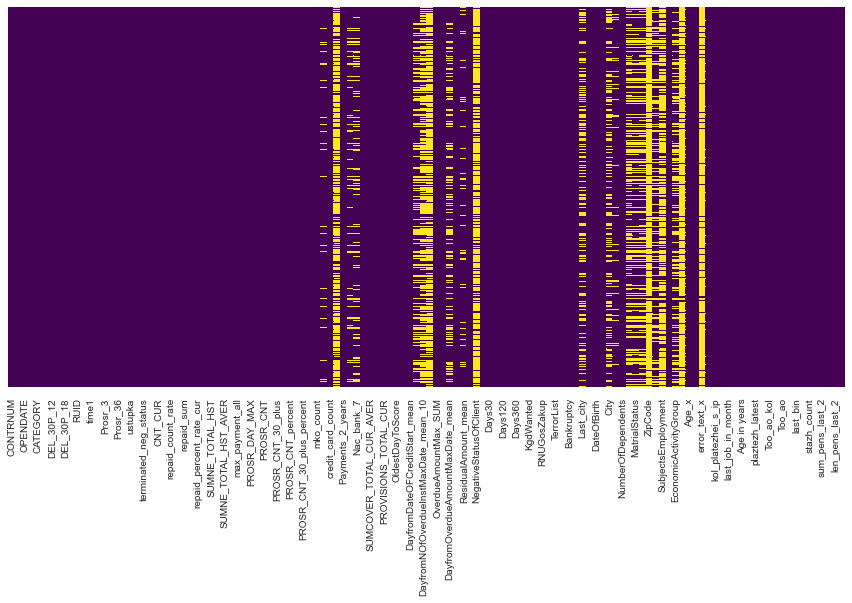

In [10]:
# посмотрим на все значения NAN
fig, ax = plt.subplots(figsize=(15,7))
sns_heatmap = sns.heatmap(df.sample(1000).isnull(), yticklabels=False, cbar=False, cmap='viridis')

как мы видим в датасете присутствует большое количество пропусков, посмотрим для начала все признаки: опишем их и посмотрим тип данных

In [11]:
columns = df.columns.tolist()
for i in columns:
    print (i, type(df[i][0]))

CONTRNUM <class 'str'>
IIN_x <class 'numpy.float64'>
OPENDATE <class 'pandas._libs.tslibs.timestamps.Timestamp'>
AMOUNTLOAN <class 'numpy.float64'>
CATEGORY <class 'str'>
PRODUCT <class 'str'>
DEL_30P_12 <class 'numpy.int64'>
DEL_90P_12 <class 'numpy.int64'>
DEL_30P_18 <class 'numpy.int64'>
DEL_90P_18 <class 'numpy.int64'>
RUID <class 'str'>
request_x <class 'str'>
time1 <class 'datetime.datetime'>
NegativeStatusOfClient_fin <class 'numpy.float64'>
Prosr_3 <class 'numpy.float64'>
Prosr_12 <class 'numpy.float64'>
Prosr_36 <class 'numpy.float64'>
Bad_MethodOfPayments <class 'numpy.float64'>
ustupka <class 'numpy.float64'>
current_neg_status <class 'numpy.float64'>
terminated_neg_status <class 'numpy.float64'>
terminated_neg_status_1 <class 'numpy.float64'>
CNT_CUR <class 'numpy.float64'>
CNT_HST <class 'numpy.float64'>
repaid_count_rate <class 'numpy.float64'>
repaid_cur_sum <class 'numpy.float64'>
repaid_sum <class 'numpy.float64'>
repaid_percent_rate <class 'numpy.float64'>
repaid_perc

### Описание полей датасета:

 - CONTRNUM - номер договора (Портфельные данные)
 - IIN_x - индивидуальный идентификационный код клиента (Портфельные данные)
 - OPENDATE - дата начала кредитногосоглашения (Портфельные данные)
 - AMOUNTLOAN - сумма по кредиту (Портфельные данные)
 - CATEGORY - категория кредитования (Портфельные данные)
 - PRODUCT - продукт кредитования (Портфельные данные)
 - DEL_90P_18  - целевая переменная (Портфельные данные)
 - RUID - RUID код клиента 
 - request -номер запроса (Кредитное бюро)
 - time1 - время запроса (Кредитное бюро)
 - NegativeStatusOfClient_fin - признак, имеет ли субъект негативный статус (Сгенер.признак))
 - Prosr_3 - просрочка более 10 000тг, более 10 дней за 3 мес по текущим кредитам (Сгенер.признак)
 - Prosr_12 - просрочка более 10 000тг, более 30 дней за 12 мес по всем кредитам (Сгенер.признак)
 - Prosr_36 - просрочка более 10 000тг, более 90 дней за 36 мес по всем кредитам (Сгенер.признак)
 - Bad_MethodOfPayments - плохие формы расчета (через страховые выплаты, выстреливание гарантии и тд) (Сгенер.признак) 
 - ustupka - уступка/переуступка прав требования по кредитному договору (Кредитное бюро)
 - current_neg_status - негативный статус хотя бы по одному из действующих договоров (Кредитное бюро)
 - terminated_neg_status - негативный статус хотя бы по одному из закрытых договоров до 60 мес (Сгенер.признак) 
 - terminated_neg_status_1 - если имеется проср. > 5 лет, то проверка на закрытый кредит после с проср. < 30 дн(Сгенер.признак) 
 - CNT_CUR - Количество текущих займов (Сгенер.признак)
 - CNT_HST - Количество закрытых займов (Сгенер.признак) 
 - repaid_count_rate - % закрытого количества кредитов от общего количества кредитов(Сгенер.признак) 
 - repaid_cur_sum - общая сумма выплаты по кредиту по действующим договорам (Сгенер.признак) 
 - repaid_sum - общая сумма выплаты по кредиту по всем договорам (Сгенер.признак) 
 - repaid_percent_rate - % закрытой суммы кредитов от общей суммы(Сгенер.признак) 
 - repaid_percent_rate_cur - % закрытой суммы кредитов от общей суммы по действующим (Сгенер.признак)
 - SUMNE_TOTAL_CUR - Сумма текущих займов (Сгенер.признак) 
 - SUMNE_TOTAL_HST - Сумма закрытых займов (Сгенер.признак) 
 - SUMNE_TOTAL_CUR_AVER - Средняя Сумма текущих займов (Если займов нет, то 0) (Сгенер.признак) 
 - SUMNE_TOTAL_HST_AVER - Средняя Сумма закрытых займов (Если займов нет, то 0) (Сгенер.признак)
 - max_payment_closed - максимальный одновременный платеж по закрытым займам (Сгенер.признак) 
 - max_payment_all - максимальный одновременный платеж по всем займам (Сгенер.признак) 
 - amount_cof - Соотношение средней суммы  текущих займов к закрытым (Сгенер.признак) 
 - PROSR_DAY_MAX - Максимальная просрочка за все время (Сгенер.признак) 
 - CNT_PAY - количество всех платежей (Сгенер.признак) 
 - PROSR_CNT - количество допущенных просрочек (Сгенер.признак) 
 - PROSR_CNT_10_plus - количество допущенных просрочек более 10 дней (Сгенер.признак) 
 - PROSR_CNT_30_plus - количество допущенных просрочек более 30 дней (Сгенер.признак) 
 - PROSR_CNT_90_plus - количество допущенных просрочек более 90 дней (Сгенер.признак) 
 - PROSR_CNT_percent - количество допущенных просрочек/количество всех платежей (Сгенер.признак) 
 - PROSR_CNT_10_plus_percent - количество допущенных просрочек более 10 дней/количество всех платежей (Сгенер.признак) 
 - PROSR_CNT_30_plus_percent - количество допущенных просрочек более 30 дней/количество всех платежей (Сгенер.признак) 
 - PROSR_CNT_90_plus_percent - количество допущенных просрочек более 90 дней/количество всех платежей (Сгенер.признак) 
 - mko_count - количество кредитов вязтых в микро-кредитных организациях
 - Max_NumberOfInstalments  - максимальное количество предстоящих платежей по кредитам (Сгенер.признак) 
 - credit_card_count - количество кредитных карт (Сгенер.признак)
 - Max_prosr_sum  - максимально просроченная сумма при просрочке более 30 дней (Сгенер.признак)
 - Payments_2_years - количество платежей в ближайшие 2 года
 - Nac_bank_8 - максимальная сумма по закрытым кредитам (признак для нац.банка)
 - Nac_bank_7 - максимальный ежемесячный платеж в ближайшие 3 года (признак для нац.банка)
 - Current_payment - максимальная сумма периодического платежа по действующим договорам (Сгенер.признак)
 - SUMCOVER_TOTAL_CUR_AVER - средняя сумма покрытия залогами по всем действующим договорам (Сгенер.признак)
 - SUMCOVER_TOTAL_HST_AVER - средняя сумма покрытия залогами по всем закрытым договорам (Сгенер.признак)
 - PROVISIONS_TOTAL_CUR  - общая сумма начисленных провизий по действующим договорам (Сгенер.признак)
 - PROVISIONS_TOTAL_HST - общая сумма начисленных провизий по закрытым договорам (Сгенер.признак)
 - OldestDayToScore - количесто дней с самой первой даты кредитования (Сгенер.признак)
 - NewestDayToScore - количесто дней с самой свежей даты кредитования (Сгенер.признак)
 - DayfromDateOFCreditStart_mean - среднее количесто дней с начала кредитования
 - DayfromNOfOverdueInstMaxDate_mean_0 - ср. кол-во дней с последней просрочки, если просрочка более 1 дня (Сгенер.признак)
 - DayfromNOfOverdueInstMaxDate_mean_10 - ср. кол-во дней с последней просрочки, если просрочка более 10 дней (Сгенер.признак) 
 - DayfromNOfOverdueInstMaxDate_mean_30 - ср. кол-во дней с последней просрочки, если просрочка более 30 дней (Сгенер.признак)
 - OverdueAmountMax_SUM - сумма максимальных просрочек (Сгенер.признак)  
 - DayfromOverdueAmountMaxDate_sum - сумма дней прошедших от максимальной задолженности (Сгенер.признак)
 - DayfromOverdueAmountMaxDate_mean - среднее количесто дней прошедших от максимальной задолженности (Сгенер.признак)
 - NumberOfOverdueInstalmentsMaxAmount_SUM - сумма задержек выплаты (Сгенер.признак)
 - ResidualAmount_mean - среднее значение остатков (Сгенер.признак)
 - DAYSOVERDUEAMOUNTMAX_mean - среднее значение максимальных просрочек (Сгенер.признак)
 - NegativeStatusOfClient - негативный статус клиента, мы создали признак, поэтому значения можно удалить (Кредитное бюро)
 - Days7  - количество запросов за 7 дней (Кредитное бюро)
 - Days30 - количество запросов за 30 дней (Кредитное бюро)
 - Days90 - количество запросов за 90 дней (Кредитное бюро)
 - Days120 - количество запросов за 120 дней (Кредитное бюро)
 - Days180 - количество запросов за 180 дней (Кредитное бюро)
 - Days360 - количество запросов за 360 дней (Кредитное бюро)
 - QamqorList - статус субъекта в списке розыска преступников, должников, без вести пропавших лиц (Кредитное бюро)
 - KgdWanted - статус субъекта в розыске Комитетом государственных доходов (Кредитное бюро)
 - QamqorAlimony - статус субъекта в розыске алиментщиков Комитетом по правовой статистике (Кредитное бюро)
 - RNUGosZakup - статус субъекта в рестре недобросовестных участников государственных закупок (Кредитное бюро)
 - FalseBusi - статус субъекта в перечне налогоплательщиков, осуществивших лжепредпринимательскую деятельность (Кредитное бюро)
 - TerrorList - статус субъекта в перечне организаций и лиц, связанных с финансированием терроризма (Кредитное бюро)
 - Areears - статус субъекта в списке плательщиков, имеющих задолженность по таможенным платежам (Кредитное бюро)
 - Bankruptcy - статус субъекта в списке несостоятельных должников/список банкротов (Кредитное бюро)
 - L150o10 - статус субъекта в списке налогоплательщиков - имеющих налоговую задолженность (Кредитное бюро)
 - Last_city - последний город проживания (Сгенер.признак)
 - IIN_y  - индивидуальный идентификационный код клиента (Кредитное бюро)
 - DateOfBirth - дата рождения субъекта (Кредитное бюро)
 - Gender  - пол субъекта (Кредитное бюро)
 - City - последний город при обновленных данных  (Кредитное бюро)
 - Region - регион при обновленных данных (Кредитное бюро)
 - NumberOfDependents - кол-во иждивенцев (Кредитное бюро)
 - Education  - уровень образования (Кредитное бюро)
 - MatrialStatus - семейное положение (Кредитное бюро)
 - EmployeesSalary - зарплата субъекта нетто (Кредитное бюро)
 - ZipCode - почтовый индекс субъекта (Кредитное бюро)
 - CellularPhone - мобильный номер субъекта (Кредитное бюро)
 - SubjectsEmployment - характер занятости клиента (Кредитное бюро)
 - Citizenship  - гражданство субъекта (Кредитное бюро)
 - EconomicActivityGroup - отрасль субъекта (Кредитное бюро)
 - CityOfBirth  - город рождения субъекта (Кредитное бюро)
 - Age_x - возраст субъекта (Кредитное бюро)
 - max_term_x - расчет максимального срока кредита (до пенс.возраста) (Сгенер.признак)
 - error_text_x - вывод ошибки при отсутствии субъекта в кредитном бюро (Кредитное бюро)
 - zarplata - заработная плата субъекта от ТОО и АО без бонусов (ГЦВП)
 - kol_platezhei_s_ip - количество платежей от ТОО и АО без бонусов, но с выплатами ИП (Сгенер.признак)
 - kol_platezhei - количество платежей всего без ИП (Сгенер.признак)
 - last_job_in_month - количество месяцев работы на последнем месте (Сгенер.признак)
 - Age_y - возраст субъекта в ГЦВП (ГЦВП)
 - Age in years - возраст в годах (Сгенер.признак)
 - max_term_y - максимальный срок до пенсии(Сгенер.признак)
 - plaztezh_latest - количество выплат за последние 48 дней с места работы, где проработал более 4 месяцев (Сгенер.признак)
 - Ip_kol - количество выплат от ИП (Сгенер.признак)
 - Too_ao_kol  - количество выплат от ТОО и АО (Сгенер.признак)
 - Ip - средние выплаты по ИП (Сгенер.признак)
 - Too_ao - средние выплаты по ТОО и АО (Сгенер.признак)
 - zarplata_all - заработная плата субъекта (Сгенер.признак)
 - last_bin - БИН с последнего места работы (Сгенер.признак)
 - error_text_y - уведомление об ошибке при попытке выгрузке данных из ГЦВП (ГЦВП)
 - stazh_count - стаж субъекта (Сгенер.признак)
 - plaztezh_latest_all - количество выплат за последние 48 дней, без ИП, без бонусов (Сгенер.признак)
 - sum_pens_last_2 - сумма выплат за последние 2 мес, без ИП, без бонусов (Сгенер.признак)
 - sum_pens_between_2_6 - сумма выплат за период между 2 и 6 месяцем, без ИП, без бонусов (Сгенер.признак)
 - len_pens_last_2 - количество выплат за последние 2 мес, без ИП, без бонусов (Сгенер.признак)
 - len_pens_between_2_6  - количество выплат за период между 2 и 6 месяцем, без ИП, без бонусов (Сгенер.признак)

In [12]:
# изменим имена всех столбцов ( все буквы маленькие)
df.columns = df.columns.str.lower()

In [13]:
# удалим сразу лишние признаки, и создадим одну целевую переменную:
df['Default']= df['del_90p_18'].apply(lambda x: 0 if x == 0 else 1)
#df['Default']= df['del_90p_12'].apply(lambda x: 0 if x == 0 else 1)

df = df.drop(columns = ['del_30p_12','del_90p_12','del_30p_18','del_90p_18'])

In [14]:
# удаляем негативный статус, тк имеем признак в числовом формате
# удаляем внутренние идентификаторы и иин/бин субъекта
# удаляем зипкод, тк имеем признак проживания по городам
# удаляем макс срок из ГЦВП, тк имеем такой же признак из  кредитного бюро
# удалим продукт, тк в нем у нас только одно значение
# удалим time1
# также считаю что регион проживания тоже не несет в себе информации, тк мы имеем более точную информацию по городам
df = df.drop(columns = ['negativestatusofclient','ruid','request_x','contrnum','iin_y','iin_x','zipcode',\
                        'max_term_y','product','time1','region','last_bin'])

In [15]:
df.dtypes.value_counts()

float64           82
object            16
int64             12
datetime64[ns]     1
dtype: int64

числовых признаков у нас 94, объектов типа object - 16 и одна колонка с типом дата/время. начнем с обработки полей типа object, больше всего пропусков в значениях ошибках, городе рождения, негативном статусе клиента и характере занятости. рассмотрим все поля подробнее.

In [16]:
df.select_dtypes(include = ['object']).isna().sum().sort_values(ascending=False)

error_text_x             182532
cityofbirth              178479
subjectsemployment       140904
education                 84013
employeessalary           75090
city                      72231
last_city                 71017
matrialstatus             67290
economicactivitygroup     66549
cellularphone             52525
citizenship                  59
gender                       34
dateofbirth                  34
error_text_y                  0
age_y                         0
category                      0
dtype: int64

сначала пройдемся по всем городам (город рождения, город проживания, последние введенные данные по городу) во всех трех признаках имеются пропуски, оставим их без изменения, а также оставим основные города страны в виде циферного значения, а все остальное отнесем к прочим

In [17]:
for i in ['cityofbirth','city','last_city']:
    CityExtract(i)

заполним все пустые ячейки 0, тк вполне возможно что субъект не предоставил ту или иную информацию о себе

In [18]:
obj_columns = df.select_dtypes(include = ['object']).columns
for i in obj_columns:
    df[i].fillna(0, inplace=True)

тк номер мобильного номера нам особо не поможет, просто определим есть номер или нет, создав тем самым бинарный признак

In [19]:
df['cellularphone']= df['cellularphone'].apply(lambda x: 1 if (len(str(x))>=10 and x!='отсутствует') else 0)

In [20]:
# df = df.apply(DateOfBirthCorr, axis=1)
# в целом мы уже имеем признак возраст, думаю дату рождения все-таки можно удалить, 
df = df.drop(columns = ['dateofbirth'])

In [21]:
# все признаки с типом object можно отнести к категориальным
cat_features = df.select_dtypes(include = ['object']).columns.tolist()
cat_features

['category',
 'gender',
 'education',
 'matrialstatus',
 'employeessalary',
 'subjectsemployment',
 'citizenship',
 'economicactivitygroup',
 'error_text_x',
 'age_y',
 'error_text_y']

In [22]:
# посмотрим на список числовых переменных
df.select_dtypes(include = ['int64']).isna().sum().sort_values(ascending=False)

Default                 0
len_pens_between_2_6    0
len_pens_last_2         0
plaztezh_latest_all     0
stazh_count             0
too_ao_kol              0
ip_kol                  0
plaztezh_latest         0
age in years            0
last_job_in_month       0
kol_platezhei           0
kol_platezhei_s_ip      0
cellularphone           0
dtype: int64

In [23]:
#увеличим список категориальных признаков, тк данные колонки не являются числовыми
cat_not_num = ['cellularphone','Default']
cat_features.extend(cat_not_num)

In [24]:
# все признаки с типом int64 можно отнести к числовым, за исключением тех что мы отнесли к категориальным
num_features = df.select_dtypes(include = ['int64']).columns.tolist()
for i in cat_not_num:
    num_features.remove(i)
len(num_features)

11

In [25]:
# теперь посмотрим на признаки с типом float
df.select_dtypes(include = ['float64']).isna().sum().sort_values(ascending=False)

dayfromnofoverdueinstmaxdate_mean_30    142126
max_prosr_sum                           142126
dayfromnofoverdueinstmaxdate_mean_10    108284
dayfromnofoverdueinstmaxdate_mean_0      57219
dayfromoverdueamountmaxdate_mean         54477
                                         ...  
zarplata                                     0
ip                                           0
too_ao                                       0
zarplata_all                                 0
amountloan                                   0
Length: 85, dtype: int64

In [26]:
# разделим эти признаки на проценты, категориальные и сгенерированные суммы

cat_not_float = ['l150o10','bankruptcy','areears','terrorlist','falsebusi','rnugoszakup',\
 'qamqoralimony','kgdwanted','qamqorlist','negativestatusofclient_fin','last_city','city','cityofbirth']

rates = ['repaid_percent_rate_cur','prosr_cnt_percent','repaid_percent_rate',\
         'repaid_count_rate','prosr_cnt_10_plus_percent','prosr_cnt_30_plus_percent',\
         'prosr_cnt_90_plus_percent', 'amount_cof']

for_log = ['amountloan','repaid_cur_sum','repaid_sum','sumne_total_cur','sumne_total_hst','sumne_total_cur_aver',\
           'sumne_total_hst_aver','max_payment_closed','max_payment_all','cnt_pay','prosr_cnt',\
           'prosr_cnt_10_plus','prosr_cnt_30_plus','prosr_cnt_90_plus','max_prosr_sum','payments_2_years',\
           'nac_bank_8','nac_bank_7','current_payment','sumcover_total_cur_aver','sumcover_total_hst_aver',\
           'provisions_total_cur','provisions_total_hst','residualamount_mean','zarplata', 'zarplata_all',\
           'sum_pens_last_2','sum_pens_between_2_6']

In [27]:
#увеличим список категориальных признаков, тк данные колонки имеют не являются числовыми

cat_features.extend(cat_not_float)

In [28]:
# здесь нужно еще подумать
float_columns = df.select_dtypes(include = ['float64']).columns
for i in float_columns:
    df[i] = df[i].replace([np.inf, -np.inf], 1)

In [29]:
#прологорифмируем все суммы
#for i in for_log:
#    Log(i)

    #тк процентные ставки при переходе на инт станут 0/1, переведем их в процентное соотношение    
for i in rates:
    df[i] = df[i]*100

In [30]:
df.select_dtypes(include = ['float64']).isna().sum().sort_values(ascending=False)

dayfromnofoverdueinstmaxdate_mean_30    142126
max_prosr_sum                           142126
dayfromnofoverdueinstmaxdate_mean_10    108284
dayfromnofoverdueinstmaxdate_mean_0      57219
dayfromoverdueamountmaxdate_mean         54477
                                         ...  
zarplata                                     0
ip                                           0
too_ao                                       0
zarplata_all                                 0
amountloan                                   0
Length: 85, dtype: int64

In [31]:
float_columns = df.select_dtypes(include = ['float64']).columns
for i in float_columns:
    df[i].fillna(0, inplace=True)

In [32]:
float_features = df.select_dtypes(include = ['float64']).columns.tolist()
for i in cat_not_float:
    float_features.remove(i)
num_features.extend(float_features)

In [33]:
float_columns = df.select_dtypes(include = ['float64']).columns
for i in float_columns:
    df[i] = df[i].astype(int)

In [34]:
df[num_features].describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
kol_platezhei_s_ip,194071.0,12.765060,4.898238,0.0,11.0,12.0,13.0,133.0
kol_platezhei,194071.0,12.614790,4.778714,0.0,11.0,12.0,13.0,133.0
last_job_in_month,194071.0,10.752013,3.228088,0.0,10.0,12.0,12.0,34.0
age in years,194071.0,35.960983,11.131384,0.0,28.0,35.0,44.0,62.0
plaztezh_latest,194071.0,1.710822,0.964165,0.0,1.0,2.0,2.0,38.0
...,...,...,...,...,...,...,...,...
ip,194071.0,0.000010,0.003210,0.0,0.0,0.0,0.0,1.0
too_ao,194071.0,0.935008,0.246512,0.0,1.0,1.0,1.0,1.0
zarplata_all,194071.0,194331.219512,178154.982745,0.0,96132.5,139120.0,216531.5,3862933.0
sum_pens_last_2,194071.0,49162.240829,49499.000136,0.0,22466.5,34550.0,56191.0,2665853.0


In [35]:
# дата начала кредитного соглашения у нас и так имеется при генерации фичей, этот признак можно бдует удалить
df = df.drop(columns = df.select_dtypes(include = ['datetime64[ns]']).columns)

In [36]:
df.dtypes.value_counts()

int32     85
int64     13
object    11
dtype: int64

с предобработкой закончили, теперь посмотрим на признаки более внимательно и возможно удалим лишнее

### разведовательный анализ данных

начнем с категориальных признаков, среди них имеется целевая переменна исключим ее

In [37]:
#посмотрим на дефолты в разрезе категорий 
def_categ = df.groupby(['category', 'Default'], dropna=False)['category'].count().unstack().fillna(0).unstack().reset_index()

Text(0.5, 1.0, 'Распределение дефолта в разрезе категорий')

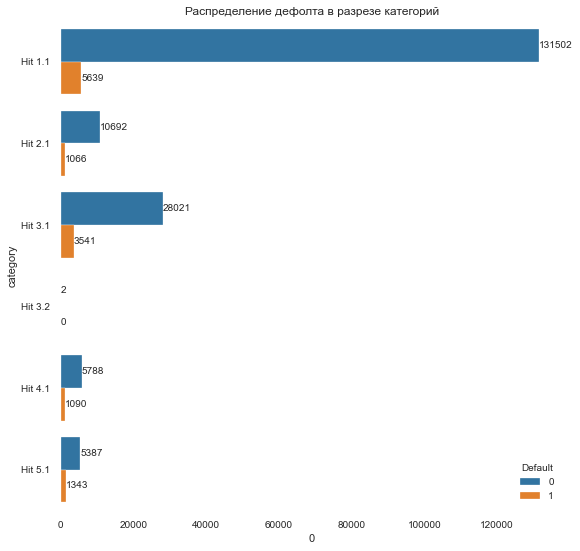

In [38]:
plt.rcParams['figure.figsize']=9,9
ax = sns.barplot(x=0, y='category', hue='Default', data=def_categ)
ShowValuesOnBars(ax, 'h', 8)
plt.title('Распределение дефолта в разрезе категорий')
plt.show()

наблюдаем градиентное увеличение количества дефолтных клиентов от хит1 к хит5

In [39]:
#посмотрим на дефолты в разрезе категорий 
def_salary = df.groupby(['employeessalary', 'Default'], dropna=False)['employeessalary'].count().unstack().fillna(0).unstack().reset_index()

Text(0.5, 1.0, 'Распределение дефолта в разрезе заработной платы')

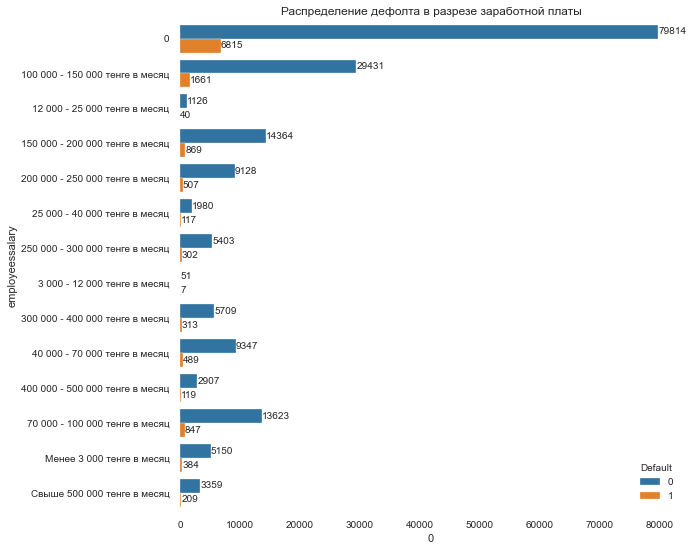

In [40]:
plt.rcParams['figure.figsize']=9,9
ax = sns.barplot(x=0, y='employeessalary', hue='Default', data=def_salary)
ShowValuesOnBars(ax, 'h', 8)
plt.title('Распределение дефолта в разрезе заработной платы')
plt.show()

большое количество дефолтов у клиентов не имеющих кредитной истории, в целом распределение равномерное

Количество пропусков: 0,
count    194071.000000
mean         12.765060
std           4.898238
min           0.000000
25%          11.000000
50%          12.000000
75%          13.000000
max         133.000000
Name: kol_platezhei_s_ip, dtype: float64,
Распределение:
12     84222
11     21517
13     19564
14      8350
10      6893
       ...  
75         1
70         1
66         1
121        1
125        1
Name: kol_platezhei_s_ip, Length: 89, dtype: int64,
Количество пропусков: 0,
count    194071.000000
mean         12.614790
std           4.778714
min           0.000000
25%          11.000000
50%          12.000000
75%          13.000000
max         133.000000
Name: kol_platezhei, dtype: float64,
Распределение:
12     86195
11     21948
13     18980
14      7677
10      6961
       ...  
67         1
66         1
65         1
63         1
125        1
Name: kol_platezhei, Length: 86, dtype: int64,
Количество пропусков: 0,
count    194071.000000
mean         10.752013
std           3.2

Name: prosr_12, dtype: int64,
Количество пропусков: 0,
count    194071.000000
mean          0.015850
std           0.986813
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max         264.000000
Name: prosr_36, dtype: float64,
Распределение:
0      193833
2          33
1          27
24         26
4          20
8          12
3          11
5          11
18         10
17         10
19          9
6           8
15          7
9           6
7           6
12          5
10          5
20          4
21          4
22          3
16          3
13          3
11          3
23          2
264         2
39          2
68          1
42          1
26          1
30          1
33          1
14          1
Name: prosr_36, dtype: int64,
Количество пропусков: 0,
count    194071.000000
mean          0.015123
std           0.123513
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: bad_methodofpayments,

Name: sumne_total_hst_aver, dtype: float64,
Распределение:
0          37600
1000000      550
500000       510
300000       464
200000       440
           ...  
672154         1
605193         1
686493         1
156062         1
249841         1
Name: sumne_total_hst_aver, Length: 122095, dtype: int64,
Количество пропусков: 0,
count    1.940710e+05
mean     3.082236e+05
std      3.726871e+06
min      0.000000e+00
25%      1.315950e+04
50%      4.998900e+04
75%      1.619040e+05
max      1.053500e+09
Name: max_payment_closed, dtype: float64,
Распределение:
0          37365
25000        308
50000        297
10000        231
41666        221
           ...  
86362          1
65361          1
1365844        1
51030          1
83607          1
Name: max_payment_closed, Length: 104266, dtype: int64,
Количество пропусков: 0,
count    1.940710e+05
mean     3.634928e+05
std      3.952108e+06
min      0.000000e+00
25%      3.666600e+04
50%      9.481100e+04
75%      2.333330e+05
max      1.05350

Name: max_prosr_sum, Length: 30770, dtype: int64,
Количество пропусков: 0,
count    194071.000000
mean         44.234662
std          30.855572
min           0.000000
25%          23.000000
50%          41.000000
75%          62.000000
max         665.000000
Name: payments_2_years, dtype: float64,
Распределение:
0      14945
24      7364
23      5641
48      3699
46      3071
       ...  
237        1
306        1
562        1
394        1
255        1
Name: payments_2_years, Length: 264, dtype: int64,
Количество пропусков: 0,
count    1.940710e+05
mean     1.142113e+06
std      4.959365e+06
min      0.000000e+00
25%      8.909650e+04
50%      4.808700e+05
75%      1.300000e+06
max      1.220000e+09
Name: nac_bank_8, dtype: float64,
Распределение:
0          37600
1000000     5670
3000000     4631
1500000     3245
500000      3242
           ...  
131119         1
181180         1
1479900        1
2147675        1
298990         1
Name: nac_bank_8, Length: 46744, dtype: int64,
Количест

Name: dayfromoverdueamountmaxdate_mean, dtype: float64,
Распределение:
 0       66018
 791        77
 1032       75
 1462       74
 1300       74
         ...  
 4469        1
-260         1
 4868        1
 4477        1
-240         1
Name: dayfromoverdueamountmaxdate_mean, Length: 4885, dtype: int64,
Количество пропусков: 0,
count    1.940710e+05
mean     1.034051e+05
std      4.800123e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.413000e+04
75%      6.111100e+04
max      1.495343e+09
Name: numberofoverdueinstalmentsmaxamount_sum, dtype: float64,
Распределение:
0         65867
1           172
2           146
3           130
4           114
          ...  
5454          1
3405          1
292162        1
27969         1
274362        1
Name: numberofoverdueinstalmentsmaxamount_sum, Length: 78171, dtype: int64,
Количество пропусков: 0,
count    1.940710e+05
mean     9.562374e+04
std      2.089188e+05
min      0.000000e+00
25%      0.000000e+00
50%      8.255000e+03
75%     

Name: zarplata_all, dtype: float64,
Распределение:
0         4018
81000      273
121500     180
162000     143
202500     130
          ... 
75883        1
69740        1
591983       1
129137       1
247623       1
Name: zarplata_all, Length: 131988, dtype: int64,
Количество пропусков: 0,
count    1.940710e+05
mean     4.916224e+04
std      4.949900e+04
min      0.000000e+00
25%      2.246650e+04
50%      3.455000e+04
75%      5.619100e+04
max      2.665853e+06
Name: sum_pens_last_2, dtype: float64,
Распределение:
0         4040
20000      610
30000      560
24000      399
40000      358
          ... 
9020         1
137896       1
191158       1
88768        1
6141         1
Name: sum_pens_last_2, Length: 80936, dtype: int64,
Количество пропусков: 0,
count    1.940710e+05
mean     9.478676e+04
std      8.956991e+04
min      0.000000e+00
25%      4.578800e+04
50%      6.723200e+04
75%      1.053845e+05
max      1.912500e+06
Name: sum_pens_between_2_6, dtype: float64,
Распределение:
0 

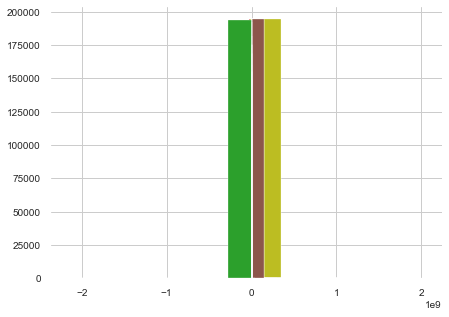

In [41]:
for i in num_features:
    ColInfo(df[i])

In [42]:
for i in num_features:
    print('Переменная: '+i+', количество выбросов:', len(sp.outliers_iqr(df[i], ret = 'outliers')))

Переменная: kol_platezhei_s_ip, количество выбросов: 36826
Переменная: kol_platezhei, количество выбросов: 36169
Переменная: last_job_in_month, количество выбросов: 29552
Переменная: age in years, количество выбросов: 3454
Переменная: plaztezh_latest, количество выбросов: 8248
Переменная: ip_kol, количество выбросов: 8367
Переменная: too_ao_kol, количество выбросов: 36231
Переменная: stazh_count, количество выбросов: 12164
Переменная: plaztezh_latest_all, количество выбросов: 16275
Переменная: len_pens_last_2, количество выбросов: 16296
Переменная: len_pens_between_2_6, количество выбросов: 37230
Переменная: amountloan, количество выбросов: 10172
Переменная: prosr_3, количество выбросов: 229
Переменная: prosr_12, количество выбросов: 298
Переменная: prosr_36, количество выбросов: 238
Переменная: bad_methodofpayments, количество выбросов: 2900
Переменная: ustupka, количество выбросов: 19087
Переменная: current_neg_status, количество выбросов: 708
Переменная: terminated_neg_status, колич

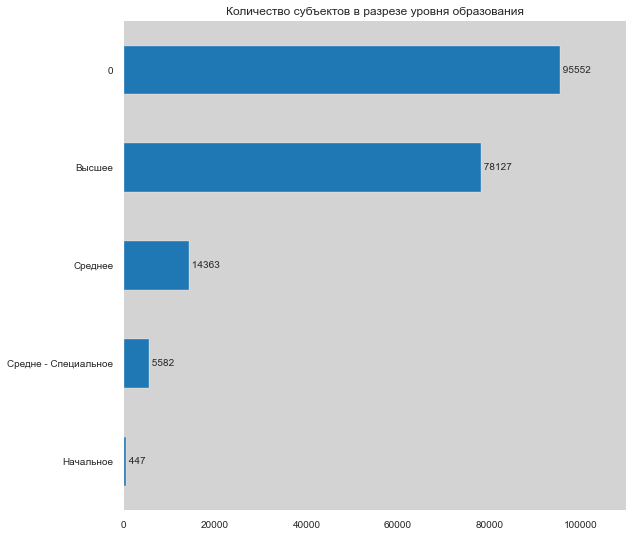

In [43]:
VizCounterBar(df,'education','Количество субъектов в разрезе уровня образования')

нужно провести более тщательный анализ признаков и подумать над выбросами, хотя выбросы критичны для лог.регрессии

### корреляционный анализ переменных

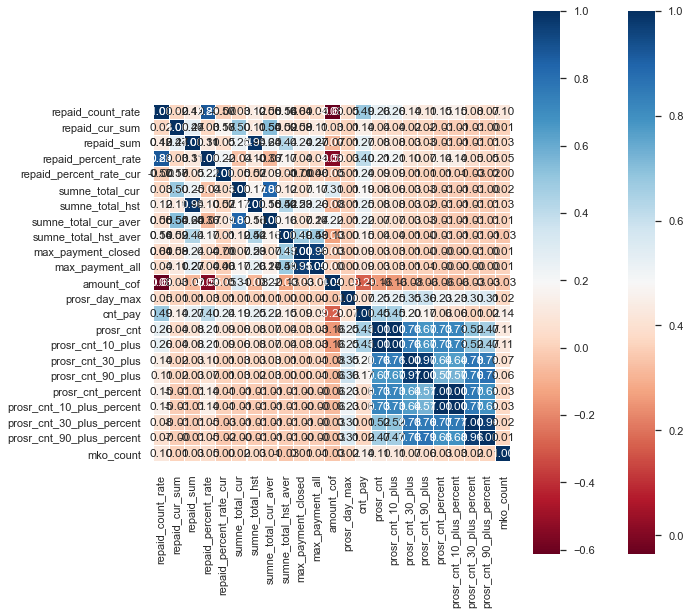

In [44]:
# теперь посмотрим на корреляцию числовых признаков между собой
sns.set (font_scale=1)
plt.subplots (figsize=(10,10))
sns.heatmap(df[num_features[0:12]].corr(), square=True, annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu");
sns.heatmap(df[num_features[22:45]].corr(), square=True, annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu");

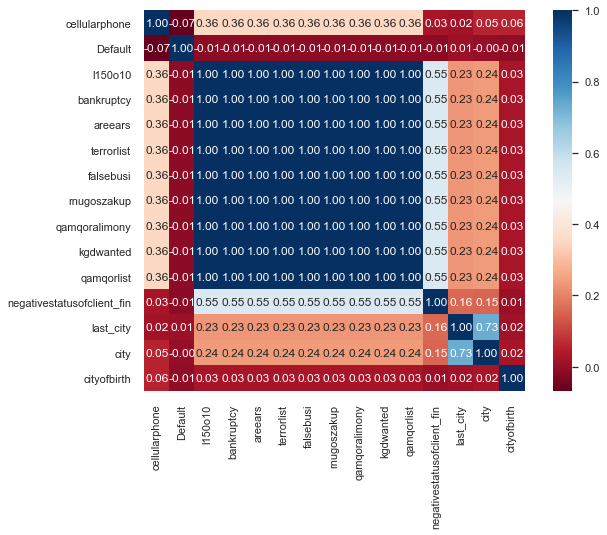

In [45]:
# теперь посмотрим на корреляцию категориальных признаков между собой
sns.set (font_scale=1)
plt.subplots (figsize=(10,7))
sns.heatmap(df[cat_features].corr(), square=True, annot=True, fmt=".2f", cmap="RdBu");

все корреляции нужно подчистить и снести к чертям все лишние, типа инфы с гос.структур

In [46]:
# сильно коррелируют города, уберем один из признаков
# информация с гос.источников не несет в себе 
#
df = df.drop(columns = ['city','economicactivitygroup'])

In [47]:
cat_features.remove('city')
cat_features.remove('economicactivitygroup')

### подготовка данных к машинному обучению

In [48]:
df2 = df.copy()

In [49]:
cat_features

['category',
 'gender',
 'education',
 'matrialstatus',
 'employeessalary',
 'subjectsemployment',
 'citizenship',
 'error_text_x',
 'age_y',
 'error_text_y',
 'cellularphone',
 'Default',
 'l150o10',
 'bankruptcy',
 'areears',
 'terrorlist',
 'falsebusi',
 'rnugoszakup',
 'qamqoralimony',
 'kgdwanted',
 'qamqorlist',
 'negativestatusofclient_fin',
 'last_city',
 'cityofbirth']

In [50]:
# для категориальных признаков мы будем использовать OneHotEncoder
for column in ['category','gender','education','matrialstatus','employeessalary','subjectsemployment',\
               'citizenship', 'error_text_x','error_text_y']:
    dummies = pd.get_dummies(df2[column])
    df2[dummies.columns] = dummies

In [51]:
df2=df2.drop(columns=['category','gender','education','matrialstatus','employeessalary','subjectsemployment',\
               'citizenship', 'error_text_x','error_text_y',0])

In [52]:
# cтандартизация
#df[num_features] = StandardScaler().fit_transform(df[num_features].values)
#df[num_features] = MinMaxScaler().fit_transform(df[num_features].values)

In [53]:
# значимость числовых переменных
all_cols = list(df2.columns)
all_num_cols = num_features
target_col = ['Default']
all_cat = [x for x in all_cols if x not in (all_num_cols+target_col)]

temp_df = df2
imp_cat = pd.Series(mutual_info_classif(temp_df[num_features], temp_df['Default'], discrete_features =True), index = num_features)
imp_cat.sort_values(inplace = True)
imp_cat.iplot(kind = 'barh')


In [54]:
top_20=imp_cat.sort_values(ascending=False)[:20]
top_20.iplot(kind = 'barh')

In [55]:
X = df.drop(['Default'], axis=1)
y = df.Default.values
X.shape

(194071, 106)

In [56]:
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=47)

In [57]:
X_tr.shape, X_val.shape

((155256, 106), (38815, 106))

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_tr, y_tr, test_size=0.3, shuffle=True, random_state=47)

In [59]:
X_train.shape,X_test.shape

((108679, 106), (46577, 106))

### обучаем разные модели и смотрим на результат

In [60]:
df2=df2.drop(columns=['age_y'])

In [61]:
X_2= df2.drop(['Default'], axis=1)
y_2 = df2.Default.values
X_2.shape

(194071, 140)

In [62]:
X_tr2, X_val2, y_tr2, y_val2 = train_test_split(X_2, y_2, test_size=0.2, shuffle=True, random_state=47)

In [63]:
mod_time=[]

In [64]:
# KNeighborsClassifier:
start = time.monotonic()
alg_ngbh = KNeighborsClassifier(n_neighbors=3)
alg_ngbh.fit(X_tr2, y_tr2)
scores = cross_val_score(alg_ngbh, X_val2, y_val2, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (k-neighbors): {}/{}".format(scores.mean(), scores.std()))
result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)

KNeighborsClassifier(n_neighbors=3)

roc_auc (k-neighbors): nan/nan
Program time: 243.312 seconds.


In [65]:
%%time
# LogisticRegression:
start = time.monotonic()
alg_log = LogisticRegression(random_state=47, max_iter=200)
alg_log.fit(X_tr2, y_tr2)
scores = cross_val_score(alg_log, X_val2, y_val2, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (logistic regression): {}/{}".format(scores.mean(), scores.std()))
result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



roc_auc (logistic regression): 0.6247736536470825/0.0076346759326023856
Program time: 100.485 seconds.
Wall time: 1min 40s


In [66]:
features=X_val2.columns
importance = alg_log.coef_[0]
#feat_imp=pd.concat(features,importance)
importance.dtype

dtype('float64')

In [67]:
pd.DataFrame(index=features, data=importance).sort_values(0,ascending=False)

,0
provisions_total_cur,9.824857e-07
provisions_total_hst,7.073446e-07
residualamount_mean,3.563378e-07
numberofoverdueinstalmentsmaxamount_sum,2.304509e-07
max_payment_closed,1.651687e-07
...,...
sumne_total_hst_aver,-1.279909e-06
sum_pens_last_2,-1.306477e-06
sum_pens_between_2_6,-3.267670e-06
zarplata,-6.073856e-06


In [68]:
# RandomForestClassifier:
start = time.monotonic()
alg_frst = RandomForestClassifier(random_state=47, n_estimators=500, min_samples_split=8, min_samples_leaf=2)
alg_frst.fit(X_tr2, y_tr2)
scores = cross_val_score(alg_frst,X_val2, y_val2, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (random forest): {}/{}".format(scores.mean(), scores.std()))
result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)

RandomForestClassifier(min_samples_leaf=2, min_samples_split=8,
                       n_estimators=500, random_state=47)

roc_auc (random forest): 0.793042741162439/0.00433798806328483
Program time: 3791.063 seconds.


In [69]:
plt.rcParams['figure.figsize'] = (5,5)
feat_importances = pd.Series(alg_frst.feature_importances_, index=X_tr2.columns)
feat_importances.sort_values(ascending=False)[:5]

amountloan                       0.030366
dayfromdateofcreditstart_mean    0.029806
oldestdaytoscore                 0.026560
max_term_x                       0.026372
sum_pens_last_2                  0.025023
dtype: float64

In [70]:
# GradientBoostingClassifier:
start = time.monotonic()
alg_gb = GradientBoostingClassifier(random_state=47)
alg_gb.fit(X_tr2, y_tr2)
scores = cross_val_score(alg_gb, X_val2, y_val2, cv=5, scoring='roc_auc', n_jobs=-1)
print("roc_auc (gradient boosting): {}/{}".format(scores.mean(), scores.std()))
result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)

GradientBoostingClassifier(random_state=47)

roc_auc (gradient boosting): 0.8068024091294583/0.002136080662905537
Program time: 2091.515 seconds.


In [71]:
plt.rcParams['figure.figsize'] = (5,5)
feat_importances = pd.Series(alg_gb.feature_importances_, index=X_tr2.columns)
feat_importances.sort_values(ascending=False)[:5]

Hit 1.1                          0.128324
dayfromdateofcreditstart_mean    0.094500
days120                          0.068470
prosr_cnt_percent                0.062179
days180                          0.060348
dtype: float64

In [72]:
cat_feat=X.columns
cat_feat

Index(['amountloan', 'category', 'negativestatusofclient_fin', 'prosr_3',
       'prosr_12', 'prosr_36', 'bad_methodofpayments', 'ustupka',
       'current_neg_status', 'terminated_neg_status',
       ...
       'ip', 'too_ao', 'zarplata_all', 'error_text_y', 'stazh_count',
       'plaztezh_latest_all', 'sum_pens_last_2', 'sum_pens_between_2_6',
       'len_pens_last_2', 'len_pens_between_2_6'],
      dtype='object', length=106)

In [73]:
start = time.monotonic()
catclass = CatBoostClassifier(eval_metric='AUC',use_best_model=True,random_state=47,verbose=False,l2_leaf_reg=1)

catclass.fit(X_train,y_train,eval_set=(X_test,y_test),cat_features=cat_feat, use_best_model=True,verbose=False)
pred = catclass.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, pred))
result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)
tpr,fpr,_=roc_curve(y_score=pred,y_true=y_test)

0.8080870434371829
Program time: 12394.813 seconds.


In [74]:
pred_val = catclass.predict_proba(X_val)[:,1]
print(roc_auc_score(y_val, pred_val))
tpr,fpr,_=roc_curve(y_score=pred_val,y_true=y_val)

0.8167076746944583


In [75]:
plt.rcParams['figure.figsize'] = (5,5)
feat_importances = pd.Series(catclass.feature_importances_, index=X_test.columns)
feat_importances.sort_values(ascending=False)[:5]

amountloan             7.394729
category               6.782976
gender                 5.285951
repaid_percent_rate    4.741876
cnt_hst                3.791583
dtype: float64

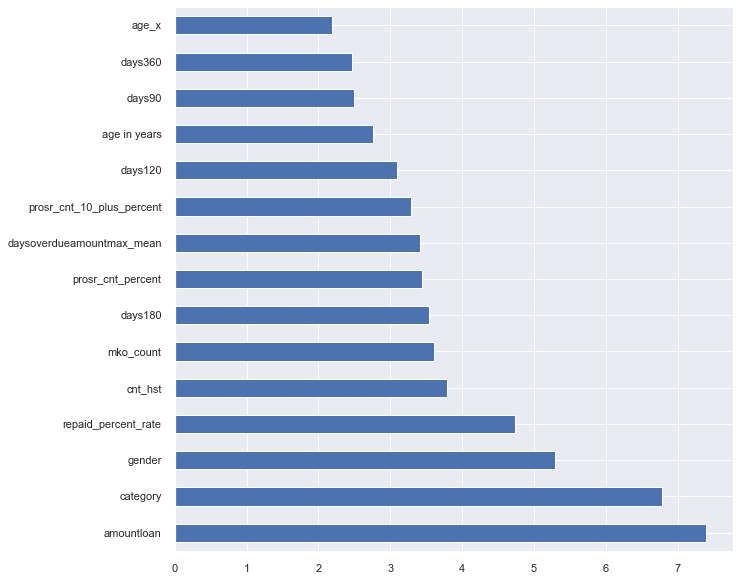

In [76]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(catclass.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

([<matplotlib.axis.XTick at 0x155ba17b548>,
 [Text(0, 0, 'GradBoost'),
  Text(0, 0, 'RandForest'),
  Text(0, 0, 'LogReg'),
  Text(0, 0, 'Catboost')])

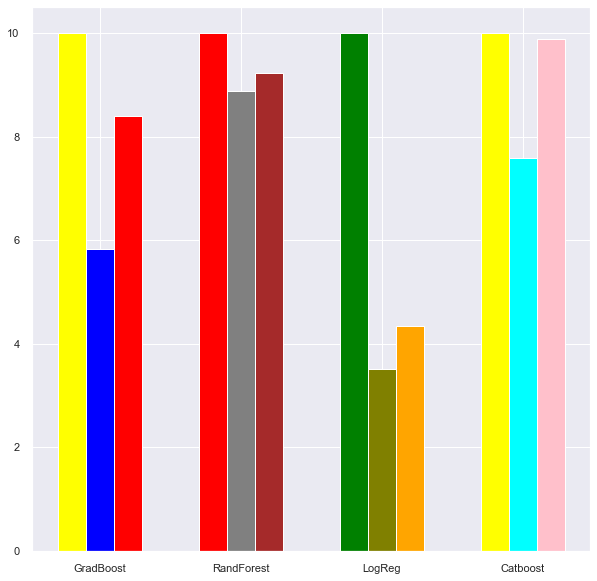

In [77]:
#график по топ 3 фичам
  
m = [10, 10, 10, 10]
z = [8.38980800885996, 9.22196442382057,4.35041716328963,9.88875382491166]
k = [5.82747346941872, 8.88682650167569,3.50417163289631,7.58411250006022]

G_axis = np.arange(4)
  
plt.bar(G_axis - 0.2, m, 0.2, label = 'Model_1', color=['yellow', 'red', 'green', 'yellow'])
plt.bar(G_axis + 0.2, z, 0.2, label = 'Model_2', color=['red', 'brown', 'orange', 'pink'])
plt.bar(G_axis, k, 0.2, label = 'Model_3', color=['blue', 'grey', 'olive', 'cyan'])
plt.xticks(range(4), ['GradBoost','RandForest','LogReg','Catboost'])  
plt.show()

Text(0.5, 1.0, 'Confusion matrix')

Confusion matrix
[[43500    57]
 [ 2944    76]]


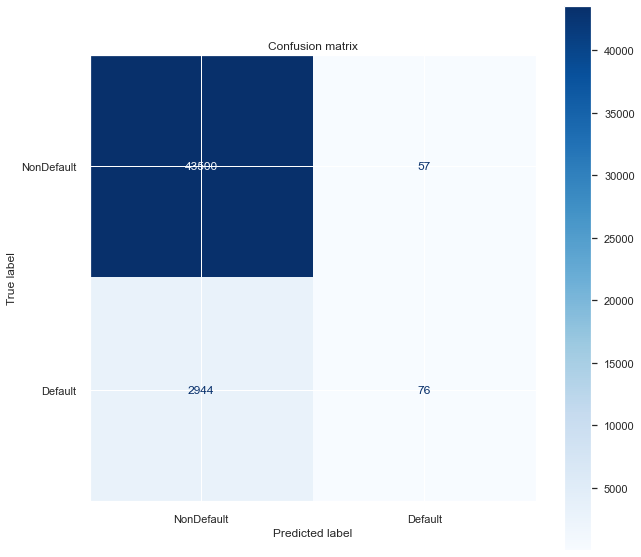

In [78]:
class_names = ['NonDefault', 'Default']

titles_options = [("Confusion matrix", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(catclass, X_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



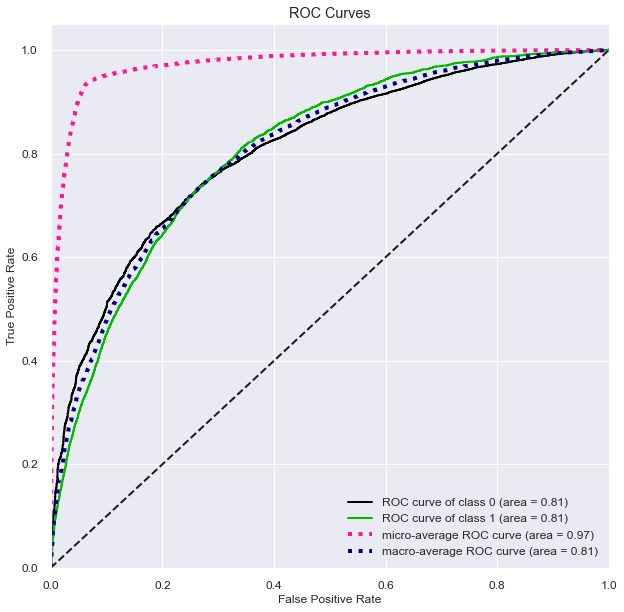

In [79]:
y_probas =catclass.predict_proba(X_test)

skplt.metrics.plot_roc_curve(y_test, y_probas)
plt.show()

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



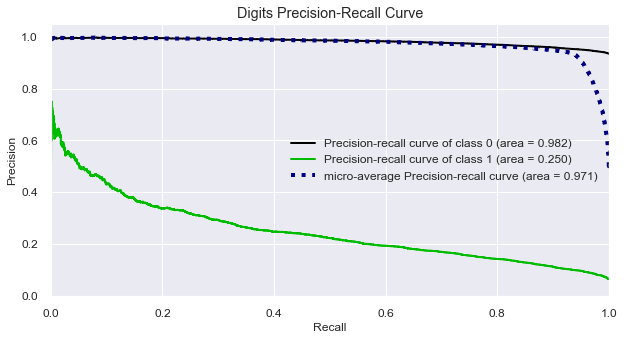

In [80]:
skplt.metrics.plot_precision_recall_curve(y_test, y_probas, title="Digits Precision-Recall Curve", figsize=(10,5));

модель которую мы получили очень плохая. Мы почти не угадали ни одного дефолтного клиента, таким образом все клиенты попали в ошибку второго рода, а это очень плохо для банка. Несмотря на это площадь под ROC кривой оказалась не такой уж плохой. Дело в том что эта кривая плохо оценивает эффективность алгоритма на несбалансированных данных, поэтому добавили Precision-Recall кривую.

In [81]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=47)
X_resampled, y_resampled = ros.fit_resample(X_tr, y_tr)

In [82]:
from imblearn.under_sampling import RandomUnderSampler
ros = RandomUnderSampler(random_state=47)
X_resampled, y_resampled = ros.fit_resample(X_tr, y_tr)

добавила андерсемплинг, таким образом искуственно уменьшим недефолтный класс, чтобы ярче увидеть признаки дефолтного класса в датасете и обучимся катбусту еще раз

In [83]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_resampled, y_resampled, test_size=0.2, shuffle=True, random_state=47)

In [84]:
%%time
catclass2 = CatBoostClassifier(eval_metric='AUC',use_best_model=True,random_state=47,\
                               iterations=160, depth=6,learning_rate=0.26,random_strength=76,\
                               bagging_temperature=42,od_type='IncToDec',od_wait=39)

Wall time: 1.5 ms


In [85]:
%%time
catclass2.fit(X_resampled, y_resampled,eval_set=(X_val,y_val),cat_features=cat_feat,use_best_model=True,verbose=False)

Wall time: 1min 46s


In [86]:
%%time
pred2 = catclass2.predict_proba(X_test_r)[:,1]
print(roc_auc_score(y_test_r, pred2))
tpr,fpr,_=roc_curve(y_score=pred2,y_true=y_test_r)

0.954429146800563
Wall time: 2.6 s


In [87]:
pred2 = catclass2.predict_proba(X_val)[:,1]
print(roc_auc_score(y_val, pred2))
tpr,fpr,_=roc_curve(y_score=pred2,y_true=y_val)

0.8116644212441264


In [89]:
def Gini(y_true, y_pred):
    # check and get number of samples
    assert y_true.shape == y_pred.shape
    n_samples = y_true.shape[0]
    
    # sort rows on prediction column 
    # (from largest to smallest)
    arr = np.array([y_true, y_pred]).transpose()
    true_order = arr[arr[:,0].argsort()][::-1,0]
    pred_order = arr[arr[:,1].argsort()][::-1,0]
    
    # get Lorenz curves
    L_true = np.cumsum(true_order) * 1.0 / np.sum(true_order)
    L_pred = np.cumsum(pred_order) * 1.0 / np.sum(pred_order)
    L_ones = np.linspace(1/n_samples, 1, n_samples)
    
    # get Gini coefficients (area between curves)
    G_true = np.sum(L_ones - L_true)
    G_pred = np.sum(L_ones - L_pred)
    
    # normalize to true Gini coefficient
    return G_pred/G_true

In [90]:
Gini(y_val, pred2)

0.6233246421992471

Text(0.5, 1.0, 'Confusion matrix')

Confusion matrix
[[25774 10494]
 [  617  1930]]


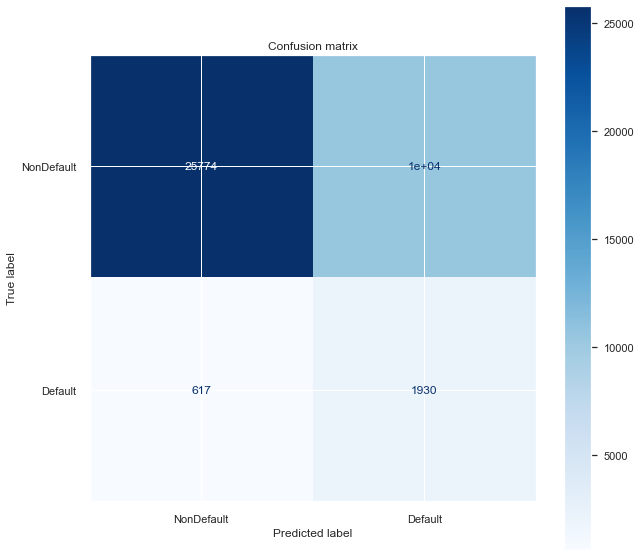

In [91]:
class_names = ['NonDefault', 'Default']

titles_options = [("Confusion matrix", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(catclass2, X_val, y_val,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



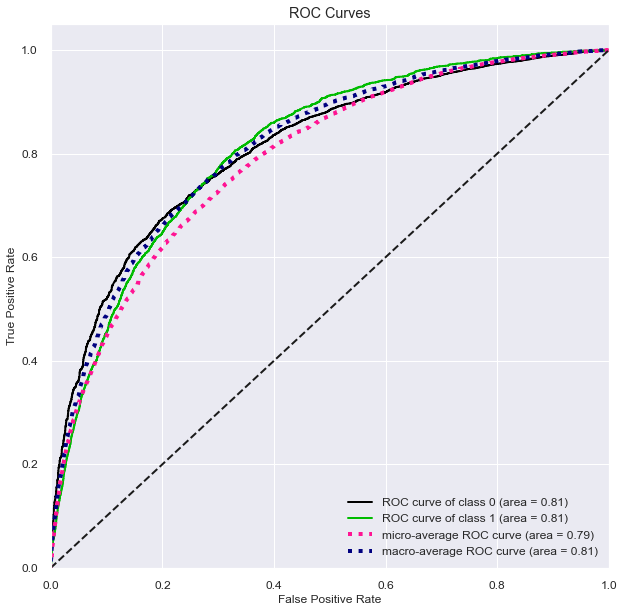

In [92]:
y_probas =catclass2.predict_proba(X_val)

skplt.metrics.plot_roc_curve(y_val, y_probas)
plt.show()

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



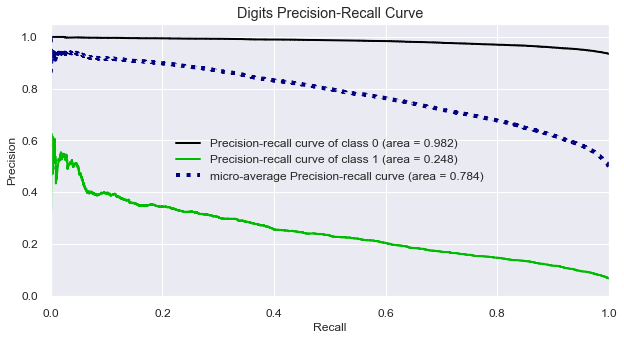

In [93]:
skplt.metrics.plot_precision_recall_curve(y_val, y_probas, title="Digits Precision-Recall Curve", figsize=(10,5));

картинка стала намного лучше, плохо видно теперь недефолтный класс, попробуем подобрать гиперпараметры с помощью оптуны

In [94]:
from catboost import Pool
import sklearn.metrics
def objective(trial):
    train_x, test_x, train_y, test_y = train_test_split(X_resampled, y_resampled, test_size=0.8, random_state=47)
    train_pool = Pool(train_x, train_y, cat_features=cat_feat)
    test_pool = Pool(test_x, test_y, cat_features=cat_feat)

    params = {
        'iterations' : trial.suggest_int('iterations', 50, 980),                         
        'depth' : trial.suggest_int('depth', 4, 10),                                       
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.01, 0.3),               
        'random_strength' :trial.suggest_int('random_strength', 0, 100),                       
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00), 
        'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        'od_wait' :trial.suggest_int('od_wait', 10, 50)
    }

    model = CatBoostClassifier(**params)
    model.fit(train_pool)
    preds = model.predict(test_pool)
    pred_labels = np.rint(preds)
    ROCAUC = sklearn.metrics.roc_auc_score(test_y, preds)
    return ROCAUC

In [95]:
# подбор гиперпараметров
if __name__ == '__main__':
    study = optuna.create_study()
    study.optimize(objective, n_trials=3)
    #print(study.best_trial)
study.best_params

[I 2021-06-13 11:14:38,182] A new study created in memory with name: no-name-c3480d63-493b-4047-a8e0-1327e04487d6


0:	learn: 0.6919144	total: 604ms	remaining: 5m 29s
1:	learn: 0.6913233	total: 1.1s	remaining: 4m 59s
2:	learn: 0.6910720	total: 1.67s	remaining: 5m 2s
3:	learn: 0.6905258	total: 2.23s	remaining: 5m 2s
4:	learn: 0.6899684	total: 2.73s	remaining: 4m 54s
5:	learn: 0.6892491	total: 3.17s	remaining: 4m 45s
6:	learn: 0.6887463	total: 3.75s	remaining: 4m 49s
7:	learn: 0.6882765	total: 4.27s	remaining: 4m 47s
8:	learn: 0.6872179	total: 4.6s	remaining: 4m 34s
9:	learn: 0.6872140	total: 4.77s	remaining: 4m 15s
10:	learn: 0.6867392	total: 5.24s	remaining: 4m 14s
11:	learn: 0.6861163	total: 5.76s	remaining: 4m 16s
12:	learn: 0.6859051	total: 6.2s	remaining: 4m 14s
13:	learn: 0.6854079	total: 6.69s	remaining: 4m 14s
14:	learn: 0.6839764	total: 7.22s	remaining: 4m 15s
15:	learn: 0.6834937	total: 7.78s	remaining: 4m 17s
16:	learn: 0.6828399	total: 8.34s	remaining: 4m 19s
17:	learn: 0.6820929	total: 8.74s	remaining: 4m 16s
18:	learn: 0.6810305	total: 9.26s	remaining: 4m 16s
19:	learn: 0.6804995	total:

158:	learn: 0.6330119	total: 1m 8s	remaining: 2m 46s
159:	learn: 0.6330062	total: 1m 8s	remaining: 2m 45s
160:	learn: 0.6329151	total: 1m 8s	remaining: 2m 44s
161:	learn: 0.6324531	total: 1m 9s	remaining: 2m 44s
162:	learn: 0.6322890	total: 1m 9s	remaining: 2m 44s
163:	learn: 0.6322065	total: 1m 10s	remaining: 2m 43s
164:	learn: 0.6318979	total: 1m 10s	remaining: 2m 43s
165:	learn: 0.6316686	total: 1m 11s	remaining: 2m 42s
166:	learn: 0.6313150	total: 1m 11s	remaining: 2m 42s
167:	learn: 0.6306443	total: 1m 12s	remaining: 2m 42s
168:	learn: 0.6305789	total: 1m 12s	remaining: 2m 41s
169:	learn: 0.6305789	total: 1m 12s	remaining: 2m 40s
170:	learn: 0.6302968	total: 1m 13s	remaining: 2m 40s
171:	learn: 0.6300570	total: 1m 13s	remaining: 2m 40s
172:	learn: 0.6298638	total: 1m 14s	remaining: 2m 39s
173:	learn: 0.6294799	total: 1m 14s	remaining: 2m 39s
174:	learn: 0.6288647	total: 1m 15s	remaining: 2m 39s
175:	learn: 0.6287081	total: 1m 15s	remaining: 2m 38s
176:	learn: 0.6282511	total: 1m 1

311:	learn: 0.6027837	total: 2m 13s	remaining: 1m 39s
312:	learn: 0.6027837	total: 2m 13s	remaining: 1m 39s
313:	learn: 0.6026533	total: 2m 13s	remaining: 1m 38s
314:	learn: 0.6025622	total: 2m 14s	remaining: 1m 38s
315:	learn: 0.6025392	total: 2m 14s	remaining: 1m 37s
316:	learn: 0.6025268	total: 2m 14s	remaining: 1m 37s
317:	learn: 0.6025268	total: 2m 15s	remaining: 1m 36s
318:	learn: 0.6024219	total: 2m 15s	remaining: 1m 36s
319:	learn: 0.6024213	total: 2m 15s	remaining: 1m 35s
320:	learn: 0.6024080	total: 2m 15s	remaining: 1m 35s
321:	learn: 0.6023431	total: 2m 16s	remaining: 1m 34s
322:	learn: 0.6022790	total: 2m 16s	remaining: 1m 34s
323:	learn: 0.6022777	total: 2m 16s	remaining: 1m 33s
324:	learn: 0.6021911	total: 2m 17s	remaining: 1m 33s
325:	learn: 0.6021266	total: 2m 17s	remaining: 1m 33s
326:	learn: 0.6021049	total: 2m 18s	remaining: 1m 32s
327:	learn: 0.6019823	total: 2m 18s	remaining: 1m 32s
328:	learn: 0.6019029	total: 2m 19s	remaining: 1m 31s
329:	learn: 0.6015058	total:

466:	learn: 0.5861748	total: 3m 15s	remaining: 33.1s
467:	learn: 0.5861748	total: 3m 15s	remaining: 32.6s
468:	learn: 0.5861748	total: 3m 15s	remaining: 32.2s
469:	learn: 0.5861032	total: 3m 16s	remaining: 31.7s
470:	learn: 0.5859661	total: 3m 16s	remaining: 31.3s
471:	learn: 0.5858092	total: 3m 17s	remaining: 30.9s
472:	learn: 0.5857327	total: 3m 17s	remaining: 30.5s
473:	learn: 0.5856381	total: 3m 18s	remaining: 30.1s
474:	learn: 0.5854540	total: 3m 18s	remaining: 29.7s
475:	learn: 0.5854540	total: 3m 19s	remaining: 29.3s
476:	learn: 0.5854540	total: 3m 19s	remaining: 28.8s
477:	learn: 0.5852894	total: 3m 19s	remaining: 28.4s
478:	learn: 0.5852847	total: 3m 19s	remaining: 27.9s
479:	learn: 0.5852847	total: 3m 19s	remaining: 27.5s
480:	learn: 0.5852847	total: 3m 19s	remaining: 27s
481:	learn: 0.5851404	total: 3m 20s	remaining: 26.6s
482:	learn: 0.5850301	total: 3m 20s	remaining: 26.2s
483:	learn: 0.5849903	total: 3m 20s	remaining: 25.7s
484:	learn: 0.5848597	total: 3m 21s	remaining: 2

[I 2021-06-13 11:18:43,901] Trial 0 finished with value: 0.7055233390607102 and parameters: {'iterations': 546, 'depth': 5, 'learning_rate': 0.012159192959485065, 'random_strength': 22, 'bagging_temperature': 0.01030026565488424, 'od_type': 'Iter', 'od_wait': 26}. Best is trial 0 with value: 0.7055233390607102.


0:	learn: 0.6883375	total: 1.9s	remaining: 30m 34s
1:	learn: 0.6872309	total: 4.36s	remaining: 35m 1s
2:	learn: 0.6870843	total: 4.77s	remaining: 25m 34s
3:	learn: 0.6823338	total: 6.78s	remaining: 27m 11s
4:	learn: 0.6823208	total: 7.28s	remaining: 23m 20s
5:	learn: 0.6813881	total: 8.2s	remaining: 21m 53s
6:	learn: 0.6813776	total: 8.46s	remaining: 19m 20s
7:	learn: 0.6794820	total: 9.95s	remaining: 19m 53s
8:	learn: 0.6776802	total: 12.2s	remaining: 21m 39s
9:	learn: 0.6737334	total: 14.5s	remaining: 23m 6s
10:	learn: 0.6727842	total: 15.5s	remaining: 22m 30s
11:	learn: 0.6727577	total: 15.8s	remaining: 21m 1s
12:	learn: 0.6685483	total: 17.8s	remaining: 21m 42s
13:	learn: 0.6682207	total: 18.8s	remaining: 21m 18s
14:	learn: 0.6669572	total: 20s	remaining: 21m 10s
15:	learn: 0.6628677	total: 22.1s	remaining: 21m 53s
16:	learn: 0.6625953	total: 22.8s	remaining: 21m 13s
17:	learn: 0.6616523	total: 23.4s	remaining: 20m 31s
18:	learn: 0.6616499	total: 23.5s	remaining: 19m 33s
19:	learn:

154:	learn: 0.5445186	total: 3m 3s	remaining: 15m 58s
155:	learn: 0.5445186	total: 3m 3s	remaining: 15m 52s
156:	learn: 0.5443983	total: 3m 4s	remaining: 15m 49s
157:	learn: 0.5436183	total: 3m 5s	remaining: 15m 48s
158:	learn: 0.5419186	total: 3m 7s	remaining: 15m 53s
159:	learn: 0.5408636	total: 3m 9s	remaining: 15m 57s
160:	learn: 0.5404548	total: 3m 12s	remaining: 16m 2s
161:	learn: 0.5400331	total: 3m 13s	remaining: 16m 2s
162:	learn: 0.5400267	total: 3m 14s	remaining: 15m 57s
163:	learn: 0.5394098	total: 3m 16s	remaining: 16m 1s
164:	learn: 0.5394098	total: 3m 17s	remaining: 15m 57s
165:	learn: 0.5386278	total: 3m 19s	remaining: 16m
166:	learn: 0.5386162	total: 3m 19s	remaining: 15m 56s
167:	learn: 0.5386162	total: 3m 19s	remaining: 15m 50s
168:	learn: 0.5386162	total: 3m 19s	remaining: 15m 43s
169:	learn: 0.5376900	total: 3m 21s	remaining: 15m 45s
170:	learn: 0.5375258	total: 3m 24s	remaining: 15m 50s
171:	learn: 0.5375072	total: 3m 24s	remaining: 15m 46s
172:	learn: 0.5366131	t

304:	learn: 0.3627529	total: 8m	remaining: 17m 22s
305:	learn: 0.3620616	total: 8m 2s	remaining: 17m 23s
306:	learn: 0.3613220	total: 8m 5s	remaining: 17m 23s
307:	learn: 0.3598941	total: 8m 7s	remaining: 17m 23s
308:	learn: 0.3593615	total: 8m 9s	remaining: 17m 23s
309:	learn: 0.3585619	total: 8m 12s	remaining: 17m 22s
310:	learn: 0.3582072	total: 8m 14s	remaining: 17m 23s
311:	learn: 0.3578587	total: 8m 16s	remaining: 17m 22s
312:	learn: 0.3575445	total: 8m 18s	remaining: 17m 22s
313:	learn: 0.3562457	total: 8m 21s	remaining: 17m 22s
314:	learn: 0.3531683	total: 8m 23s	remaining: 17m 22s
315:	learn: 0.3520216	total: 8m 25s	remaining: 17m 22s
316:	learn: 0.3512005	total: 8m 28s	remaining: 17m 21s
317:	learn: 0.3505767	total: 8m 30s	remaining: 17m 21s
318:	learn: 0.3495199	total: 8m 32s	remaining: 17m 21s
319:	learn: 0.3479887	total: 8m 35s	remaining: 17m 21s
320:	learn: 0.3470451	total: 8m 37s	remaining: 17m 21s
321:	learn: 0.3451577	total: 8m 40s	remaining: 17m 21s
322:	learn: 0.3439

453:	learn: 0.2519919	total: 13m 57s	remaining: 15m 45s
454:	learn: 0.2508854	total: 13m 59s	remaining: 15m 44s
455:	learn: 0.2503528	total: 14m 1s	remaining: 15m 43s
456:	learn: 0.2499681	total: 14m 3s	remaining: 15m 41s
457:	learn: 0.2493323	total: 14m 6s	remaining: 15m 40s
458:	learn: 0.2488110	total: 14m 8s	remaining: 15m 39s
459:	learn: 0.2485781	total: 14m 10s	remaining: 15m 37s
460:	learn: 0.2479117	total: 14m 13s	remaining: 15m 36s
461:	learn: 0.2478906	total: 14m 15s	remaining: 15m 35s
462:	learn: 0.2474180	total: 14m 18s	remaining: 15m 34s
463:	learn: 0.2469147	total: 14m 20s	remaining: 15m 32s
464:	learn: 0.2459038	total: 14m 22s	remaining: 15m 31s
465:	learn: 0.2450435	total: 14m 24s	remaining: 15m 29s
466:	learn: 0.2447872	total: 14m 27s	remaining: 15m 28s
467:	learn: 0.2439546	total: 14m 29s	remaining: 15m 27s
468:	learn: 0.2434733	total: 14m 31s	remaining: 15m 25s
469:	learn: 0.2428563	total: 14m 34s	remaining: 15m 24s
470:	learn: 0.2425307	total: 14m 36s	remaining: 15m 

601:	learn: 0.1794991	total: 19m 47s	remaining: 12m
602:	learn: 0.1794655	total: 19m 50s	remaining: 11m 58s
603:	learn: 0.1793866	total: 19m 53s	remaining: 11m 57s
604:	learn: 0.1789853	total: 19m 56s	remaining: 11m 55s
605:	learn: 0.1783869	total: 19m 58s	remaining: 11m 54s
606:	learn: 0.1783150	total: 20m 1s	remaining: 11m 52s
607:	learn: 0.1778270	total: 20m 3s	remaining: 11m 50s
608:	learn: 0.1774086	total: 20m 5s	remaining: 11m 48s
609:	learn: 0.1772520	total: 20m 8s	remaining: 11m 47s
610:	learn: 0.1767462	total: 20m 10s	remaining: 11m 45s
611:	learn: 0.1764113	total: 20m 12s	remaining: 11m 43s
612:	learn: 0.1760750	total: 20m 15s	remaining: 11m 41s
613:	learn: 0.1758468	total: 20m 18s	remaining: 11m 40s
614:	learn: 0.1757321	total: 20m 20s	remaining: 11m 38s
615:	learn: 0.1753788	total: 20m 22s	remaining: 11m 36s
616:	learn: 0.1748667	total: 20m 25s	remaining: 11m 35s
617:	learn: 0.1741811	total: 20m 27s	remaining: 11m 33s
618:	learn: 0.1740008	total: 20m 30s	remaining: 11m 31s


750:	learn: 0.1392230	total: 25m 56s	remaining: 7m 27s
751:	learn: 0.1389336	total: 25m 58s	remaining: 7m 25s
752:	learn: 0.1385479	total: 26m 1s	remaining: 7m 23s
753:	learn: 0.1383230	total: 26m 3s	remaining: 7m 21s
754:	learn: 0.1380183	total: 26m 6s	remaining: 7m 19s
755:	learn: 0.1375379	total: 26m 9s	remaining: 7m 17s
756:	learn: 0.1372686	total: 26m 11s	remaining: 7m 15s
757:	learn: 0.1371847	total: 26m 13s	remaining: 7m 13s
758:	learn: 0.1371759	total: 26m 16s	remaining: 7m 11s
759:	learn: 0.1370725	total: 26m 18s	remaining: 7m 9s
760:	learn: 0.1368243	total: 26m 20s	remaining: 7m 7s
761:	learn: 0.1367873	total: 26m 23s	remaining: 7m 6s
762:	learn: 0.1365388	total: 26m 25s	remaining: 7m 4s
763:	learn: 0.1361881	total: 26m 28s	remaining: 7m 1s
764:	learn: 0.1358279	total: 26m 30s	remaining: 6m 59s
765:	learn: 0.1355055	total: 26m 32s	remaining: 6m 57s
766:	learn: 0.1351074	total: 26m 35s	remaining: 6m 55s
767:	learn: 0.1348982	total: 26m 37s	remaining: 6m 54s
768:	learn: 0.13476

901:	learn: 0.1078099	total: 31m 53s	remaining: 2m 17s
902:	learn: 0.1075011	total: 31m 55s	remaining: 2m 15s
903:	learn: 0.1073317	total: 31m 58s	remaining: 2m 13s
904:	learn: 0.1071464	total: 32m	remaining: 2m 11s
905:	learn: 0.1068857	total: 32m 2s	remaining: 2m 9s
906:	learn: 0.1066963	total: 32m 5s	remaining: 2m 7s
907:	learn: 0.1065049	total: 32m 7s	remaining: 2m 5s
908:	learn: 0.1063286	total: 32m 10s	remaining: 2m 3s
909:	learn: 0.1061429	total: 32m 12s	remaining: 2m 1s
910:	learn: 0.1058564	total: 32m 15s	remaining: 1m 58s
911:	learn: 0.1057834	total: 32m 17s	remaining: 1m 56s
912:	learn: 0.1055840	total: 32m 19s	remaining: 1m 54s
913:	learn: 0.1054427	total: 32m 22s	remaining: 1m 52s
914:	learn: 0.1052668	total: 32m 24s	remaining: 1m 50s
915:	learn: 0.1050876	total: 32m 27s	remaining: 1m 48s
916:	learn: 0.1049057	total: 32m 30s	remaining: 1m 46s
917:	learn: 0.1048915	total: 32m 32s	remaining: 1m 44s
918:	learn: 0.1048710	total: 32m 35s	remaining: 1m 42s
919:	learn: 0.1047238	

[I 2021-06-13 11:53:39,727] Trial 1 finished with value: 0.714800922516773 and parameters: {'iterations': 967, 'depth': 9, 'learning_rate': 0.052566094665969246, 'random_strength': 36, 'bagging_temperature': 5.420275472568576, 'od_type': 'Iter', 'od_wait': 40}. Best is trial 0 with value: 0.7055233390607102.


0:	learn: 0.6917810	total: 595ms	remaining: 5m 38s
1:	learn: 0.6877290	total: 1.09s	remaining: 5m 9s
2:	learn: 0.6866570	total: 1.56s	remaining: 4m 55s
3:	learn: 0.6865973	total: 1.83s	remaining: 4m 18s
4:	learn: 0.6865827	total: 2s	remaining: 3m 45s
5:	learn: 0.6817390	total: 2.64s	remaining: 4m 8s
6:	learn: 0.6809673	total: 3.21s	remaining: 4m 18s
7:	learn: 0.6808937	total: 3.6s	remaining: 4m 13s
8:	learn: 0.6804295	total: 4.14s	remaining: 4m 18s
9:	learn: 0.6804212	total: 4.19s	remaining: 3m 54s
10:	learn: 0.6803848	total: 4.45s	remaining: 3m 46s
11:	learn: 0.6779602	total: 4.77s	remaining: 3m 41s
12:	learn: 0.6779545	total: 4.94s	remaining: 3m 31s
13:	learn: 0.6779286	total: 5.26s	remaining: 3m 29s
14:	learn: 0.6778803	total: 5.48s	remaining: 3m 22s
15:	learn: 0.6760961	total: 5.77s	remaining: 3m 19s
16:	learn: 0.6743376	total: 6.32s	remaining: 3m 25s
17:	learn: 0.6737041	total: 6.8s	remaining: 3m 28s
18:	learn: 0.6725450	total: 7.39s	remaining: 3m 34s
19:	learn: 0.6718775	total: 7

158:	learn: 0.5910541	total: 56.6s	remaining: 2m 26s
159:	learn: 0.5910265	total: 57.1s	remaining: 2m 26s
160:	learn: 0.5910265	total: 57.2s	remaining: 2m 25s
161:	learn: 0.5905840	total: 57.4s	remaining: 2m 24s
162:	learn: 0.5900216	total: 57.8s	remaining: 2m 24s
163:	learn: 0.5896932	total: 58.3s	remaining: 2m 24s
164:	learn: 0.5887419	total: 58.4s	remaining: 2m 23s
165:	learn: 0.5883423	total: 59s	remaining: 2m 23s
166:	learn: 0.5883423	total: 59.2s	remaining: 2m 22s
167:	learn: 0.5883134	total: 59.6s	remaining: 2m 22s
168:	learn: 0.5874084	total: 1m	remaining: 2m 22s
169:	learn: 0.5869334	total: 1m	remaining: 2m 22s
170:	learn: 0.5869072	total: 1m	remaining: 2m 21s
171:	learn: 0.5866818	total: 1m 1s	remaining: 2m 21s
172:	learn: 0.5860881	total: 1m 1s	remaining: 2m 21s
173:	learn: 0.5860881	total: 1m 1s	remaining: 2m 20s
174:	learn: 0.5857412	total: 1m 2s	remaining: 2m 20s
175:	learn: 0.5855443	total: 1m 2s	remaining: 2m 19s
176:	learn: 0.5845331	total: 1m 3s	remaining: 2m 19s
177:

312:	learn: 0.5041657	total: 2m 9s	remaining: 1m 46s
313:	learn: 0.5039717	total: 2m 10s	remaining: 1m 46s
314:	learn: 0.5037398	total: 2m 10s	remaining: 1m 45s
315:	learn: 0.5030609	total: 2m 10s	remaining: 1m 45s
316:	learn: 0.5028205	total: 2m 11s	remaining: 1m 44s
317:	learn: 0.5023311	total: 2m 11s	remaining: 1m 44s
318:	learn: 0.5018043	total: 2m 12s	remaining: 1m 44s
319:	learn: 0.5015647	total: 2m 12s	remaining: 1m 43s
320:	learn: 0.5012898	total: 2m 13s	remaining: 1m 43s
321:	learn: 0.5011414	total: 2m 13s	remaining: 1m 43s
322:	learn: 0.5010224	total: 2m 14s	remaining: 1m 42s
323:	learn: 0.5006467	total: 2m 14s	remaining: 1m 42s
324:	learn: 0.5003268	total: 2m 15s	remaining: 1m 42s
325:	learn: 0.5001533	total: 2m 15s	remaining: 1m 41s
326:	learn: 0.4998760	total: 2m 16s	remaining: 1m 41s
327:	learn: 0.4994497	total: 2m 16s	remaining: 1m 40s
328:	learn: 0.4990494	total: 2m 17s	remaining: 1m 40s
329:	learn: 0.4989834	total: 2m 17s	remaining: 1m 40s
330:	learn: 0.4987510	total: 

466:	learn: 0.4675429	total: 3m 31s	remaining: 46.6s
467:	learn: 0.4674475	total: 3m 31s	remaining: 46.2s
468:	learn: 0.4673778	total: 3m 32s	remaining: 45.8s
469:	learn: 0.4670999	total: 3m 32s	remaining: 45.3s
470:	learn: 0.4669667	total: 3m 33s	remaining: 44.9s
471:	learn: 0.4667307	total: 3m 34s	remaining: 44.5s
472:	learn: 0.4664291	total: 3m 34s	remaining: 44s
473:	learn: 0.4661168	total: 3m 35s	remaining: 43.6s
474:	learn: 0.4659698	total: 3m 35s	remaining: 43.1s
475:	learn: 0.4658401	total: 3m 36s	remaining: 42.7s
476:	learn: 0.4656945	total: 3m 36s	remaining: 42.3s
477:	learn: 0.4654952	total: 3m 37s	remaining: 41.9s
478:	learn: 0.4651449	total: 3m 37s	remaining: 41.4s
479:	learn: 0.4650758	total: 3m 38s	remaining: 40.9s
480:	learn: 0.4650019	total: 3m 38s	remaining: 40.5s
481:	learn: 0.4648780	total: 3m 39s	remaining: 40.1s
482:	learn: 0.4645942	total: 3m 39s	remaining: 39.6s
483:	learn: 0.4644366	total: 3m 40s	remaining: 39.2s
484:	learn: 0.4641748	total: 3m 40s	remaining: 3

[I 2021-06-13 11:58:24,752] Trial 2 finished with value: 0.7207993270332188 and parameters: {'iterations': 570, 'depth': 5, 'learning_rate': 0.054913483805838416, 'random_strength': 81, 'bagging_temperature': 55.580179031636135, 'od_type': 'IncToDec', 'od_wait': 41}. Best is trial 0 with value: 0.7055233390607102.


{'iterations': 546,
 'depth': 5,
 'learning_rate': 0.012159192959485065,
 'random_strength': 22,
 'bagging_temperature': 0.01030026565488424,
 'od_type': 'Iter',
 'od_wait': 26}

In [96]:
optuna.visualization.plot_slice(study)

In [97]:
%%time
catclass3 = CatBoostClassifier(eval_metric='AUC',use_best_model=True,random_state=47,\
                               iterations=160, depth=6,learning_rate=0.26,random_strength=76,\
                               bagging_temperature=42,od_type='IncToDec',od_wait=39)

Wall time: 502 µs


In [98]:
%%time
catclass3.fit(X_resampled, y_resampled,eval_set=(X_val,y_val),cat_features=cat_feat,use_best_model=True,verbose=False)

Wall time: 1min 52s


In [99]:
%%time
pred3 = catclass3.predict_proba(X_test_r)[:,1]
print(roc_auc_score(y_test_r, pred3))
tpr,fpr,_=roc_curve(y_score=pred3,y_true=y_test_r)

0.954429146800563
Wall time: 2.37 s


In [100]:
pred3 = catclass3.predict_proba(X_val)[:,1]
print(roc_auc_score(y_val, pred3))
tpr,fpr,_=roc_curve(y_score=pred3,y_true=y_val)

0.8116644212441264


In [101]:
Gini(y_val, pred3)

0.6233246421992471

Text(0.5, 1.0, 'Confusion matrix')

Confusion matrix
[[25774 10494]
 [  617  1930]]


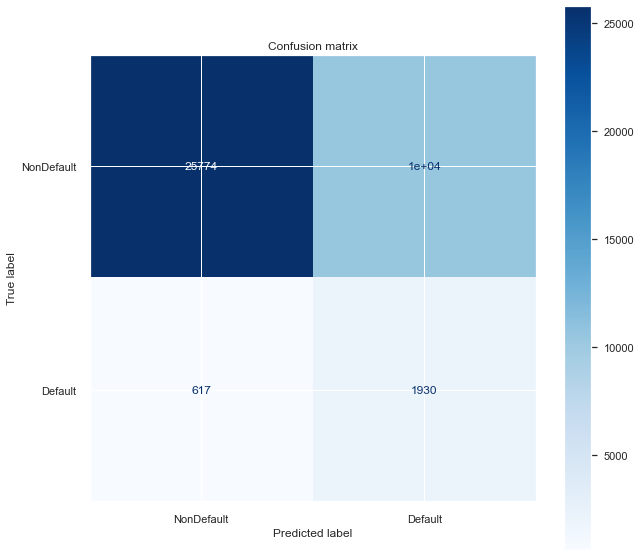

In [102]:
class_names = ['NonDefault', 'Default']

titles_options = [("Confusion matrix", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(catclass3, X_val, y_val,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



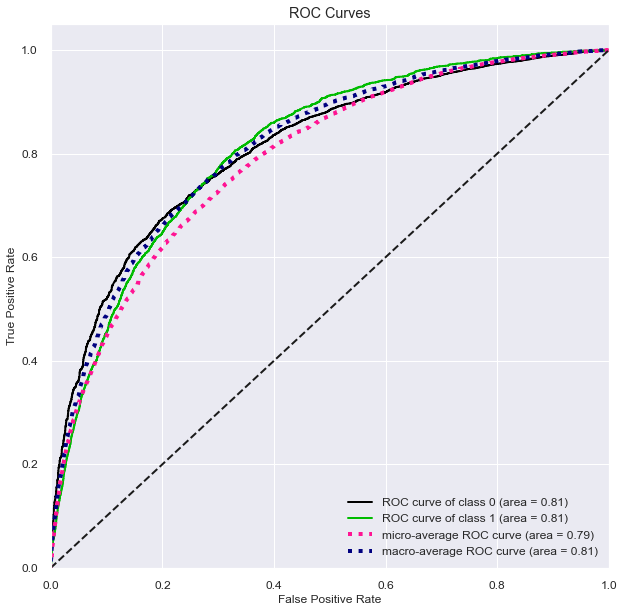

In [103]:
y_probas =catclass3.predict_proba(X_val)

skplt.metrics.plot_roc_curve(y_val, y_probas)
plt.show()

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



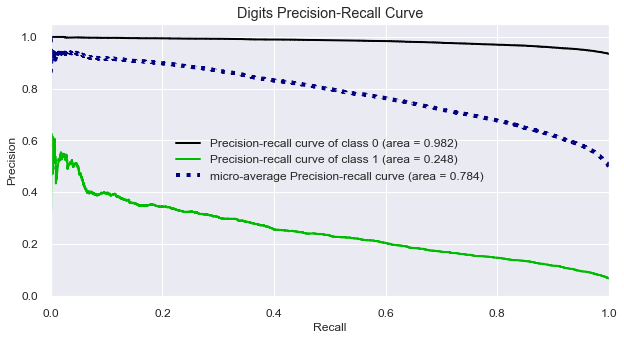

In [104]:
skplt.metrics.plot_precision_recall_curve(y_val, y_probas, title="Digits Precision-Recall Curve", figsize=(10,5));

In [105]:
def cat_model(y_train, X_train, X_test, y_test):
    model = CatBoostRegressor(iterations=780,
                          learning_rate=0.2,
                          depth=6,
                          random_state=47,
                          random_strength=76,
                          bagging_temperature=42,
                          eval_metric='AUC',
                          od_type='IncToDec',
                          od_wait=39,
                          od_pval=0.002)
    
    model.fit(X_train, y_train,
              cat_features=cat_feat,
              eval_set=(X_test, y_test),
              verbose=False,
              use_best_model=True,
              plot=False)

    return(model)


также попылась обучить модель катбуст регрессию, которая обучалась 3 фолдами через кросс-валидацию, возможно будет полезной

In [106]:
score_ls = []
N_FOLDS = 3
splits = list(KFold(n_splits=N_FOLDS, shuffle=True, random_state=47).split(X_resampled, y_resampled))

for idx, (train_idx, test_idx) in tqdm(enumerate(splits), total=N_FOLDS,):
    X_train, y_train, X_test, y_test = X_resampled.iloc[train_idx], y_resampled[train_idx], X_resampled.iloc[test_idx],y_resampled[test_idx]
    # model for this fold
    model = cat_model(y_train, X_train, X_test, y_test,)
    # score model on test
    test_predict = model.predict(X_test)
    test_score = roc_auc_score(y_test, test_predict)
    score_ls.append(test_score)
    print(f"{idx+1} Fold Test ROC AUC: {roc_auc_score(y_test, test_predict):0.3f}")
    model.save_model(f'catboost_fold_{idx+1}.model')
    
print(f'Mean Score: {np.mean(score_ls):0.3f}')
print(f'Std Score: {np.std(score_ls):0.4f}')
print(f'Max Score: {np.max(score_ls):0.3f}')
print(f'Min Score: {np.min(score_ls):0.3f}')
#''', 

  0%|          | 0/3 [00:00<?, ?it/s]

1 Fold Test ROC AUC: 0.803


 33%|███▎      | 1/3 [16:48<33:36, 1008.33s/it]

2 Fold Test ROC AUC: 0.800


 67%|██████▋   | 2/3 [39:30<18:34, 1114.61s/it]

3 Fold Test ROC AUC: 0.798


100%|██████████| 3/3 [58:58<00:00, 1179.63s/it]


Mean Score: 0.801
Std Score: 0.0020
Max Score: 0.803
Min Score: 0.798


тк для банковского сектора важен показатель Джини, добавила его в расчеты

In [107]:
Gini(y_val, pred2)

0.6233246421992471

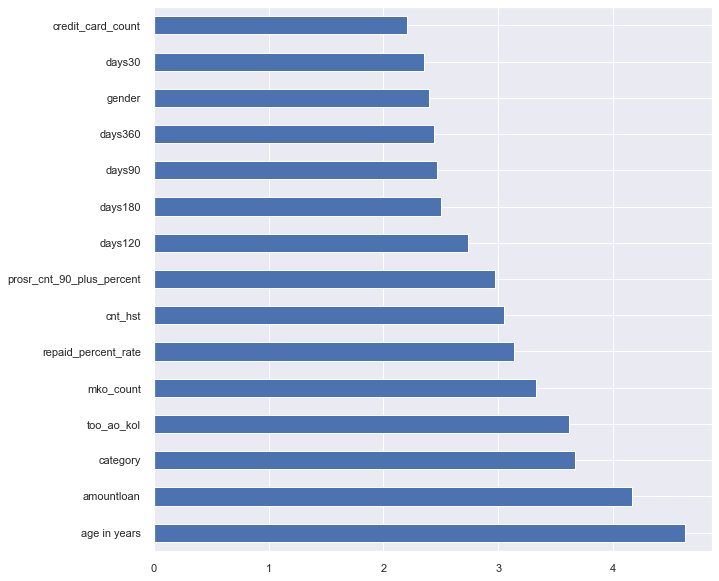

In [108]:
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [109]:
pred2 = catclass.predict_proba(X_val)[:,1]
print(roc_auc_score(y_val, pred2))
tpr,fpr,_=roc_curve(y_score=pred2,y_true=y_val)

0.8167076746944583


In [110]:
pred2 = model.predict(X_val)
print(roc_auc_score(y_val, pred2))
tpr,fpr,_=roc_curve(y_score=pred2,y_true=y_val)

0.8060400772957101


Text(0.5, 1.0, 'Confusion matrix')

Confusion matrix
[[104998  40126]
 [  1193   8939]]


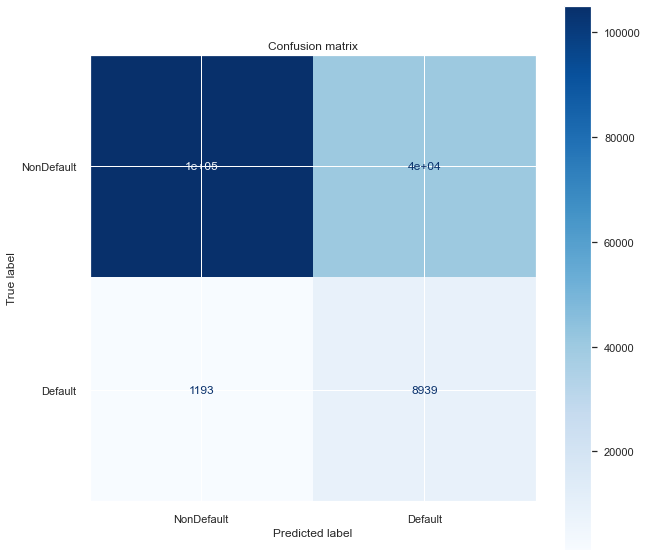

In [111]:
class_names = ['NonDefault', 'Default']

titles_options = [("Confusion matrix", None)]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(catclass2, X_tr, y_tr,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=None)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.



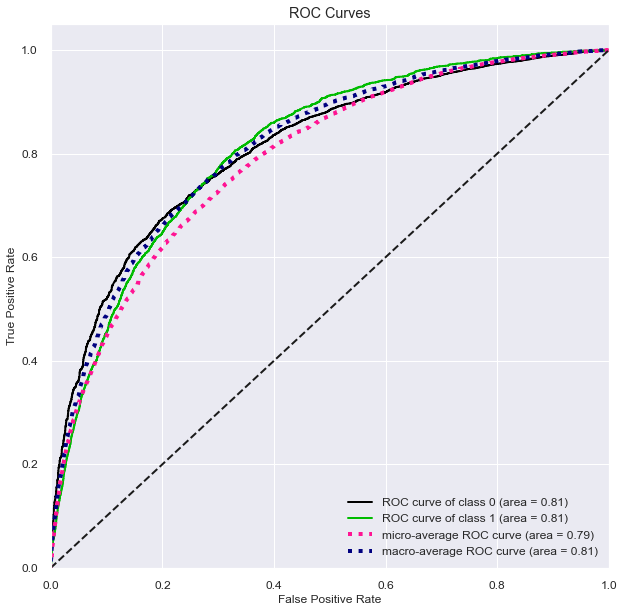

In [112]:
y_probas2 =catclass2.predict_proba(X_val)

skplt.metrics.plot_roc_curve(y_val, y_probas2)
plt.show()

C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning:

Function plot_precision_recall_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_precision_recall instead.



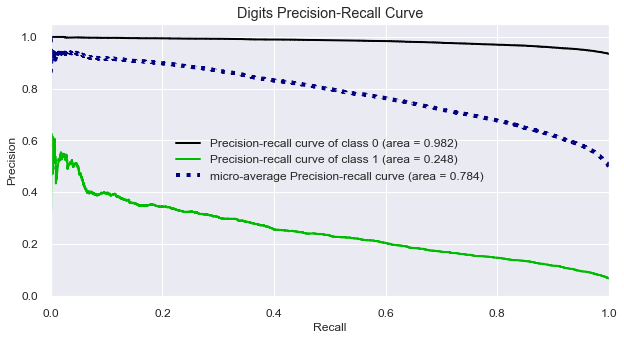

In [113]:
skplt.metrics.plot_precision_recall_curve(y_val, y_probas2, title="Digits Precision-Recall Curve", figsize=(10,5));

добавила пробу в датасет и попробую посчитать возможный доход банка при запуске данной модели на бой: недополученную прибыль Банка по ложно-отрицательным + съеэкономленные банковские средства по истинно-отрицательным признакам

In [114]:
y_probas_all =catclass2.predict_proba(X)

In [115]:
df['proba'] = y_probas_all[:,1]

In [116]:
df.head()

,amountloan,category,negativestatusofclient_fin,prosr_3,prosr_12,prosr_36,bad_methodofpayments,ustupka,current_neg_status,terminated_neg_status,terminated_neg_status_1,cnt_cur,cnt_hst,repaid_count_rate,repaid_cur_sum,repaid_sum,repaid_percent_rate,repaid_percent_rate_cur,sumne_total_cur,sumne_total_hst,sumne_total_cur_aver,sumne_total_hst_aver,max_payment_closed,max_payment_all,amount_cof,prosr_day_max,cnt_pay,prosr_cnt,prosr_cnt_10_plus,prosr_cnt_30_plus,prosr_cnt_90_plus,prosr_cnt_percent,prosr_cnt_10_plus_percent,prosr_cnt_30_plus_percent,prosr_cnt_90_plus_percent,mko_count,max_numberofinstalments,credit_card_count,max_prosr_sum,payments_2_years,nac_bank_8,nac_bank_7,current_payment,sumcover_total_cur_aver,sumcover_total_hst_aver,provisions_total_cur,provisions_total_hst,oldestdaytoscore,newestdaytoscore,dayfromdateofcreditstart_mean,dayfromnofoverdueinstmaxdate_mean_0,dayfromnofoverdueinstmaxdate_mean_10,dayfromnofoverdueinstmaxdate_mean_30,overdueamountmax_sum,dayfromoverdueamountmaxdate_sum,dayfromoverdueamountmaxdate_mean,numberofoverdueinstalmentsmaxamount_sum,residualamount_mean,daysoverdueamountmax_mean,days7,days30,days90,days120,days180,days360,qamqorlist,kgdwanted,qamqoralimony,rnugoszakup,falsebusi,terrorlist,areears,bankruptcy,l150o10,last_city,gender,numberofdependents,education,matrialstatus,employeessalary,cellularphone,subjectsemployment,citizenship,cityofbirth,age_x,max_term_x,error_text_x,zarplata,kol_platezhei_s_ip,kol_platezhei,last_job_in_month,age_y,age in years,plaztezh_latest,ip_kol,too_ao_kol,ip,too_ao,zarplata_all,error_text_y,stazh_count,plaztezh_latest_all,sum_pens_last_2,sum_pens_between_2_6,len_pens_last_2,len_pens_between_2_6,Default,proba
0,940000,Hit 1.1,1,0,0,0,0,0,0,0,0,2,6,75,725031,1922688,80,60,1191768,1197657,595884,199609,41426,53457,298,7,131,6,6,0,0,4,4,0,0,0,48,1,0,34,695000,9864,53457,0,9032,0,0,4052,391,2070,349,0,0,28685,1559,779,28685,0,1,0,0,0,0,0,2,2,2,2,2,2,2,2,2,2,0,Мужской,0,Высшее,Женат/замужем,200 000 - 250 000 тенге в месяц,1,Полная занятость,Казахстан,0,54,104,0,79110,12,12,12,"relativedelta(years=+54, months=+3, days=+9, h...",54,2,0,12,0,1,79110,Ok,12,2,22600,36000,2,4,0,0.128998
1,210000,Hit 1.1,1,0,0,0,0,0,0,0,0,0,4,100,0,2165000,100,0,0,2165000,0,541250,55034,55034,0,19,104,8,8,0,0,7,7,0,0,0,34,2,0,4,1000000,21944,0,0,0,0,0,3919,184,2391,2950,2950,0,44137,6891,3034,1440,111646,3,0,0,0,1,3,3,2,2,2,2,2,2,2,2,2,0,Мужской,0,0,0,0,1,0,Казахстан,0,35,334,0,108342,12,12,12,"relativedelta(years=+35, months=+1, days=+5, h...",35,1,0,12,0,1,108342,Ok,11,1,26753,53499,2,4,0,0.295393
2,1000000,Hit 1.1,1,0,0,0,0,0,0,0,0,2,3,60,401946,1173945,54,29,1380000,771999,690000,257333,24001,44914,268,0,89,0,0,0,0,0,0,0,0,0,60,0,0,52,480000,24001,44914,0,0,0,0,2394,279,1280,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,2,2,2,2,2,2,2,2,2,0,Мужской,0,0,0,0,1,0,Казахстан,0,34,339,0,68789,12,12,12,"relativedelta(years=+34, months=+8, days=+2, h...",34,2,0,12,0,1,113186,Ok,11,3,27278,56564,3,4,0,0.178274
3,2000000,Hit 1.1,0,0,0,0,1,1,0,0,6,1,14,93,1172529,16457515,81,23,5000000,15284986,5000000,1091784,692502,743600,457,11,262,11,11,0,0,4,4,0,0,0,230,0,0,51,4842587,692502,51097,13007000,113678,0,51486,4711,77,3119,2971,3850,0,246048,18638,2201,219739,0,3,0,0,1,1,1,1,2,2,2,2,2,2,2,2,2,0,Мужской,0,0,Женат/замужем,0,1,0,Казахстан,5,47,187,0,697389,12,12,12,"relativedelta(years=+47, months=+4, days=+27, ...",47,1,0,12,0,1,697389,Ok,12,1,233361,283223,2,4,0,0.035867
4,1784915,Hit 1.1,1,0,0,0,0,0,0,0,0,1,7,87,76320,1921632,56,4,1551633,1845312,1551633,263616,93855,225794,588,2,117,5,5,0,0,4,4,0,0,0,60,3,0,40,600440,93855,200794,0,12553,0,0,3687,138,1947,1295,0,0,106607,3050,1016,105467,465299,0,0,1,5,8,12,14,2,2,2,2,2,2,2,2,2,5,Женский,0,0,Женат/замужем,70 000 - 100 000 тенге в месяц,1,0,Казахстан,0,34,300,0,121127,11,11,11,"relativedelta(years=+34, months=+11, days=+8, ...",34,1,0,11,0,1,121127,Ok,9,1,41731,47993,2,4,0,0.591286


In [117]:
def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
    facet.set_xticklabels(rotation=90)
    

In [118]:
df['bins']=df['proba']*10
df['bins']=df['bins'].astype('int')

In [119]:
aggregation_functions = { 'amountloan':'sum', 'amountloan':'count'}
df.groupby(by=['bins', 'Default'], as_index = False).aggregate(aggregation_functions)  


,bins,Default,amountloan
0,0,0,26569
1,0,1,36
2,1,0,34966
3,1,1,147
4,2,0,26610
5,2,1,298
6,3,0,23305
7,3,1,510
8,4,0,19322
9,4,1,819


In [120]:
#возьмем только последние два класса
list1 = []
for i in range(8,10):
    skolko_sekonomila = df[(df['bins']>=i)&(df['Default']==1)]['amountloan'].sum()
    skolko_bank_ne_zarabotal = df[(df['bins']>=i)&(df['Default']==0)]['amountloan'].sum() * 0.06
    moya_polza = skolko_sekonomila - skolko_bank_ne_zarabotal
    dict1 ={'bin': i, 'skolko_sekonomila':skolko_sekonomila, 'skolko_bank_ne_zarabotal':skolko_bank_ne_zarabotal,\
            'moya_polza':moya_polza}
    list1.append(dict1)
a1 = pd.DataFrame(list1, columns=['bin', 'skolko_sekonomila', 'skolko_bank_ne_zarabotal', 'moya_polza'])
a1

,bin,skolko_sekonomila,skolko_bank_ne_zarabotal,moya_polza
0,8,10580391083,7.933599e+08,9.787031e+09
1,9,6129065875,1.821302e+08,5.946936e+09


C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:723: UserWarning:

Using the barplot function without specifying `order` is likely to produce an incorrect plot.



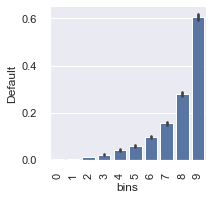

In [121]:
plot_categories(df , cat = 'bins' , target = 'Default', color='red')

In [122]:
# показатели h2o мне не понравились, в целом не лучше катбуста, но намного дольше считает, убираем пока
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.291-b10, mixed mode)
  Starting server from C:\Users\aabdraimova\AppData\Local\Continuum\anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\AABDRA~1\AppData\Local\Temp\tmp78mfoq8k
  JVM stdout: C:\Users\AABDRA~1\AppData\Local\Temp\tmp78mfoq8k\h2o_AABDRAIMOVA_started_from_python.out
  JVM stderr: C:\Users\AABDRA~1\AppData\Local\Temp\tmp78mfoq8k\h2o_AABDRAIMOVA_started_from_python.err
  Server is running at http://127.0.0.1:54327
Connecting to H2O server at http://127.0.0.1:54327 ... successful.


H2O_cluster_uptime:,25 secs
H2O_cluster_timezone:,Asia/Almaty
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,24 days
H2O_cluster_name:,H2O_from_python_AABDRAIMOVA_t5hne9
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.752 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"locked, healthy"


In [123]:
dff_h2o=df.drop(columns=['proba','bins'])

In [124]:
x_h2o = df.columns[0:-3]
y_h2o = "Default"
df_h2o = h2o.H2OFrame(dff_h2o)
df_h2o = df_h2o.asfactor()

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [ ]:
train, test = df_h2o.split_frame ( ratios = [0.8])

In [ ]:
start = time.monotonic()
aml = H2OAutoML(max_models=20, seed=47)
aml.train(x=x_h2o, y=y_h2o, training_frame=train)
lb = aml.leaderboard
lb.head(rows=lb.nrows)
aml.leader
result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)

In [ ]:
preds = aml.predict(test)
preds.head()

In [ ]:
a=h2o.as_list(preds)
b=h2o.as_list(test[y])
roc_auc_score(b['Default'], a['p1'])

In [ ]:
##попробуем также модель LightAutoML
N_THREADS = 24 # threads cnt for LightAutoML models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 47 # fixed random state for various reasons
TEST_SIZE = 0.2 # Test size for metric check
TIMEOUT = 3600 # Time in seconds for automl run
TARGET_NAME = 'Default' # Target column name

In [ ]:
import os
import time
import torch

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

In [ ]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

def auc_metric(y_true, y_pred, **kwargs):
    return roc_auc_score(y_true, (y_pred > 0.12).astype(int), **kwargs)

task = Task('binary', metric = auc_metric)
roles = {'target': TARGET_NAME}

In [ ]:
for i in df2.columns:
    df2[i].fillna(0, inplace=True)

In [ ]:
tr_data, ts_data = train_test_split(df2, test_size=TEST_SIZE, \
                                    stratify=df2[TARGET_NAME],\
                                    random_state=RANDOM_STATE)

In [ ]:
%%time 
start = time.monotonic()
automl = TabularAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
                       verbose = 0
                      )
oof_pred = automl.fit_predict(tr_data, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

result = time.monotonic() - start
print("Program time: {:>.3f}".format(result) + " seconds.")
mod_time.append(result)

In [ ]:
mod_time

In [ ]:
%%time

## Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [ ]:
oof_pred.data.fillna(0,inplace=True)

In [ ]:
def roc_m(y_true, y_pred, bound = 0.5):
    return roc_auc_score(y_true, y_pred)
best_score = -1
best_w = None
for w in np.arange(0, 1.01, 0.01):
    cur_score = roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])
    if cur_score > best_score:
        best_score = cur_score
        best_w = w
        print(best_w, best_score)
        
print('='*10)
print(best_w, best_score)

In [ ]:
%%time

test_pred = automl.predict(ts_data)
print('Prediction for test data:\n{}\nShape = {}'
              .format(test_pred, test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(roc_auc_score(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])))
print('TEST score: {}'.format(roc_auc_score(ts_data[TARGET_NAME].values, test_pred.data[:, 0])))